<a href="https://colab.research.google.com/github/oamerl/machine-learning-projects/blob/main/Machine-Learning/bank_loyalty_score_prediction/Bank_Loyalty_Score_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing needed libraries

import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import scipy
from scipy import stats
from scipy.stats import skew, norm
import scipy.stats as stats
!pip install -q missingno
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
!pip install -q yellowbrick
from yellowbrick.regressor import ResidualsPlot

from sklearn.preprocessing import RobustScaler
from sklearn import linear_model
import sklearn.model_selection as ms
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso

from datetime import datetime

!pip install -q cliffs-delta
from cliffs_delta import cliffs_delta

# the following code ensures that you can see your (print) results for multiple tasks within a coding block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# change max_columns that defaults to 20 to be able to see all features statistics
pd.options.display.max_columns = 100
pd.options.display.width = None

In [ ]:
conda install -c conda-forge jupyter_contrib_nbextensions

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ 

Descriping how to make use of merchants.csv, historical transactions.csv, and new merchant transactions.csv, for user loyalty prediction.

* The first possible way we tried is to merge all the 4 available files such that we can use all available features in the datasets. However when we did this the merchnats.csv data was found to be noisy and contains inconsistent records, even after its preparation it still introduced null values when merging with other datasets indicating that there is a possible issue that not all merchant identifiers existed in the transactions sets so we decided not to use the merchants data and we assumed that the relation between loyalty score and the merchants data can be neglected.

* The way we proceeded then is to merge the userscore data with the historical transactions.csv, and new merchant transactions.csv files using "card_id".
* Its important to note that for historical transactions.csv, and new merchant transactions.csv we needed first to get an aggregate of all transactions of each user such that we have one entry per card_id
* Also we splitted the historical transactions.csv based on the authorization flag such that when we do aggregation we aggregate authorized transactions together and unauthorized transactions together
* Then we merged the aggregated userscore with authorized historical transactions, unauthorized historical transactions and new merchant transactions obtaining a final aggregated dataset

# **Reading the Data and Indentifying its Structure and Properties**

In [ ]:
# Reading data

historical_transactions = pd.read_csv("/kaggle/input/cisc839-a1/data/historical_transactions.csv")
new_transactions = pd.read_csv("/kaggle/input/cisc839-a1/data/new_merchant_transactions.csv")
merchants = pd.read_csv("/kaggle/input/cisc839-a1/data/merchants.csv")
userscore = pd.read_csv("/kaggle/input/cisc839-a1/data/userscore.csv")

## General Information about Data and its Structure

In [ ]:
# Understanding data structure

historical_transactions.head(5)
new_transactions.head(5)
merchants.head(5)
userscore.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


,card_id,first_active_month,feature_1,feature_2,feature_3,score
0,C_ID_92a2005557,Jun-17,5,2,1,-0.820283
1,C_ID_3d0044924f,Jan-17,4,1,0,0.392913
2,C_ID_d639edf6cd,Aug-16,2,2,0,0.688056
3,C_ID_186d6a6901,Sep-17,4,3,0,0.142495
4,C_ID_cdbd2c0db2,Nov-17,1,3,0,-0.159749


In [ ]:
# Printing some information about the data

historical_transactions.info()
print("\n")
new_transactions.info()
print("\n")
merchants.info()
print("\n")
userscore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   city_id               int64  
 3   category_1            object 
 4   installments          int64  
 5   category_3            object 
 6   merchant_category_id  int64  
 7   merchant_id           object 
 8   month_lag             int64  
 9   purchase_amount       float64
 10  purchase_date         object 
 11  category_2            float64
 12  state_id              int64  
 13  subsector_id          int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Dtype  
---  ------                -----  
 0   authorized_flag       object 
 1   card_id               object 
 2   cit

In [ ]:
# Understanding data statistics

historical_transactions.describe(include = 'all')
new_transactions.describe(include = 'all')
merchants.describe(include = 'all')
userscore.describe(include = 'all')

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
count,29112361,29112361,2.911236e+07,29112361,2.911236e+07,28934202,2.911236e+07,28973880,2.911236e+07,2.911236e+07,29112361,2.645950e+07,2.911236e+07,2.911236e+07
unique,2,325540,NaN,2,NaN,3,NaN,326311,NaN,NaN,16395300,NaN,NaN,NaN
top,Y,C_ID_3d3dfdc692,NaN,N,NaN,A,NaN,M_ID_00a6ca8a8a,NaN,NaN,2017-11-24 00:00:00,NaN,NaN,NaN
freq,26595452,5582,NaN,27028332,NaN,15411747,NaN,1115097,NaN,NaN,26184,NaN,NaN,NaN
mean,NaN,NaN,1.293256e+02,NaN,6.484954e-01,NaN,4.810130e+02,NaN,-4.487294e+00,3.640090e-02,NaN,2.194578e+00,1.056679e+01,2.684839e+01
std,NaN,NaN,1.042563e+02,NaN,2.795577e+00,NaN,2.493757e+02,NaN,3.588800e+00,1.123522e+03,NaN,1.531896e+00,6.366927e+00,9.692793e+00
min,NaN,NaN,-1.000000e+00,NaN,-1.000000e+00,NaN,-1.000000e+00,NaN,-1.300000e+01,-7.469078e-01,NaN,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,NaN,NaN,5.300000e+01,NaN,0.000000e+00,NaN,3.070000e+02,NaN,-7.000000e+00,-7.203559e-01,NaN,1.000000e+00,9.000000e+00,1.900000e+01
50%,NaN,NaN,9.000000e+01,NaN,0.000000e+00,NaN,4.540000e+02,NaN,-4.000000e+00,-6.883495e-01,NaN,1.000000e+00,9.000000e+00,2.900000e+01
75%,NaN,NaN,2.120000e+02,NaN,1.000000e+00,NaN,7.050000e+02,NaN,-2.000000e+00,-6.032543e-01,NaN,3.000000e+00,1.600000e+01,3.400000e+01


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
count,1963031,1963031,1.963031e+06,1963031,1.963031e+06,1907109,1.963031e+06,1936815,1.963031e+06,1.963031e+06,1963031,1.851286e+06,1.963031e+06,1.963031e+06
unique,1,290001,NaN,2,NaN,3,NaN,226129,NaN,NaN,1667025,NaN,NaN,NaN
top,Y,C_ID_b7ebee6539,NaN,N,NaN,A,NaN,M_ID_00a6ca8a8a,NaN,NaN,2017-11-18 00:00:00,NaN,NaN,NaN
freq,1963031,109,NaN,1899935,NaN,922244,NaN,23018,NaN,NaN,582,NaN,NaN,NaN
mean,NaN,NaN,1.343867e+02,NaN,6.829643e-01,NaN,4.309701e+02,NaN,1.476515e+00,-5.509690e-01,NaN,2.197841e+00,1.088067e+01,2.597624e+01
std,NaN,NaN,1.015152e+02,NaN,1.584069e+00,NaN,2.463385e+02,NaN,4.994483e-01,6.940043e-01,NaN,1.528125e+00,6.038542e+00,1.012908e+01
min,NaN,NaN,-1.000000e+00,NaN,-1.000000e+00,NaN,-1.000000e+00,NaN,1.000000e+00,-7.468928e-01,NaN,1.000000e+00,-1.000000e+00,-1.000000e+00
25%,NaN,NaN,6.900000e+01,NaN,0.000000e+00,NaN,2.780000e+02,NaN,1.000000e+00,-7.166294e-01,NaN,1.000000e+00,9.000000e+00,1.900000e+01
50%,NaN,NaN,1.100000e+02,NaN,1.000000e+00,NaN,3.670000e+02,NaN,1.000000e+00,-6.748406e-01,NaN,1.000000e+00,9.000000e+00,2.900000e+01
75%,NaN,NaN,2.120000e+02,NaN,1.000000e+00,NaN,6.830000e+02,NaN,2.000000e+00,-5.816162e-01,NaN,3.000000e+00,1.500000e+01,3.400000e+01


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
count,334696,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696,334696,334696,334683.000000,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,334696,334696.000000,334696.000000,322809.000000
unique,334633,NaN,NaN,NaN,NaN,NaN,2,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN
top,M_ID_42697d5d44,NaN,NaN,NaN,NaN,NaN,N,E,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
freq,4,NaN,NaN,NaN,NaN,NaN,327657,177104,175309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238596,NaN,NaN,NaN
mean,NaN,31028.736143,423.131663,25.116404,0.011476,0.008103,NaN,NaN,NaN,13.832993,inf,2.994108,2.165079e+01,inf,5.947397,2.522771e+01,inf,11.599335,NaN,102.917926,11.860942,2.380002
std,NaN,31623.043426,252.898046,9.807371,1.098154,1.070497,NaN,NaN,NaN,2395.489999,NaN,0.095247,3.947108e+03,NaN,0.394936,5.251842e+03,NaN,1.520138,NaN,107.090673,6.176889,1.562661
min,NaN,1.000000,-1.000000,-1.000000,-0.057471,-0.057471,NaN,NaN,NaN,-82.130000,3.334953e-01,1.000000,-8.213000e+01,1.670447e-01,1.000000,-8.213000e+01,9.832954e-02,1.000000,NaN,-1.000000,-1.000000,1.000000
25%,NaN,3612.000000,222.000000,19.000000,-0.057471,-0.057471,NaN,NaN,NaN,0.880000,9.236499e-01,3.000000,8.500000e-01,9.022475e-01,6.000000,8.500000e-01,8.983333e-01,12.000000,NaN,-1.000000,9.000000,1.000000
50%,NaN,19900.000000,373.000000,27.000000,-0.057471,-0.057471,NaN,NaN,NaN,1.000000,1.016667e+00,3.000000,1.010000e+00,1.026961e+00,6.000000,1.020000e+00,1.043361e+00,12.000000,NaN,69.000000,9.000000,2.000000
75%,NaN,51707.250000,683.000000,33.000000,-0.047556,-0.047556,NaN,NaN,NaN,1.160000,1.146522e+00,3.000000,1.230000e+00,1.215575e+00,6.000000,1.290000e+00,1.266480e+00,12.000000,NaN,182.000000,16.000000,4.000000


,card_id,first_active_month,feature_1,feature_2,feature_3,score
count,201917,201917,201917.000000,201917.000000,201917.000000,201917.000000
unique,201917,75,NaN,NaN,NaN,NaN
top,C_ID_92a2005557,Sep-17,NaN,NaN,NaN,NaN
freq,1,13878,NaN,NaN,NaN,NaN
mean,NaN,NaN,3.105311,1.745410,0.565569,-0.393636
std,NaN,NaN,1.186160,0.751362,0.495683,3.850500
min,NaN,NaN,1.000000,1.000000,0.000000,-33.219281
25%,NaN,NaN,2.000000,1.000000,0.000000,-0.883110
50%,NaN,NaN,3.000000,2.000000,1.000000,-0.023437
75%,NaN,NaN,4.000000,2.000000,1.000000,0.765453


# **Data Cleaning - Missing Values and Duplicates Checks**

## Missing Values Check

In [ ]:
# Checking missing values

# Count the total number of missing values for all features
print("The historical_transactions data contains a total of", historical_transactions.isnull().values.sum(), "missing values")
print("The new_transactions data contains a total of", new_transactions.isnull().values.sum(), "missing values")
print("The merchants data contains a total of", merchants.isnull().values.sum(), "missing values")
print("The userscore data contains a total of", userscore.isnull().values.sum(), "missing values")
print("\n")

# Column-wise summary of missing values count for each feature for each table
missing_historical_transactions = historical_transactions.isna().sum().sort_values(ascending = False)
missing_new_transactions = new_transactions.isna().sum().sort_values(ascending = False)
missing_merchants = merchants.isna().sum().sort_values(ascending = False)
missing_userscore = userscore.isna().sum().sort_values(ascending = False)

# filtering on features that have missing values
print("For historical_transactions there are", len(missing_historical_transactions[missing_historical_transactions>0]), "features that have missing values")
print("----------------------------------------")
missing_historical_transactions[missing_historical_transactions>0]
print("\n")

print("For new_transactions there are", len(missing_new_transactions[missing_new_transactions>0]), "features that have missing values")
print("----------------------------------------")
missing_new_transactions[missing_new_transactions>0]
print("\n")

print("For merchants there are", len(missing_merchants[missing_merchants>0]), "features that have missing values")
print("----------------------------------------")
missing_merchants[missing_merchants>0]
print("\n")

print("For userscore there are", len(missing_userscore[missing_userscore>0]), "features that have missing values")
print("----------------------------------------")
missing_userscore[missing_userscore>0]


The historical_transactions data contains a total of 2969504 missing values
The new_transactions data contains a total of 193883 missing values
The merchants data contains a total of 11926 missing values
The userscore data contains a total of 0 missing values


For historical_transactions there are 3 features that have missing values
----------------------------------------


category_2     2652864
category_3      178159
merchant_id     138481
dtype: int64



For new_transactions there are 3 features that have missing values
----------------------------------------


category_2     111745
category_3      55922
merchant_id     26216
dtype: int64



For merchants there are 4 features that have missing values
----------------------------------------


category_2         11887
avg_sales_lag6        13
avg_sales_lag12       13
avg_sales_lag3        13
dtype: int64



For userscore there are 0 features that have missing values
----------------------------------------


Series([], dtype: int64)

In [ ]:
# Visualize missing values using msno package
hist_tr_miss_col_names = missing_historical_transactions[missing_historical_transactions>0].index.values # features that do have missing values, columns names
new_tr_miss_col_names = missing_new_transactions[missing_new_transactions>0].index.values # features that do have missing values, columns names
merch_miss_col_names = missing_merchants[missing_merchants>0].index.values # features that do have missing values, columns names

<Axes: >

<Axes: >

<Axes: >

/opt/conda/lib/python3.10/site-packages/matplotlib/image.py:180: UserWarning: Data with more than 2**24 rows cannot be accurately displayed. Downsampling to less than 2**24 rows before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**24 rows'))


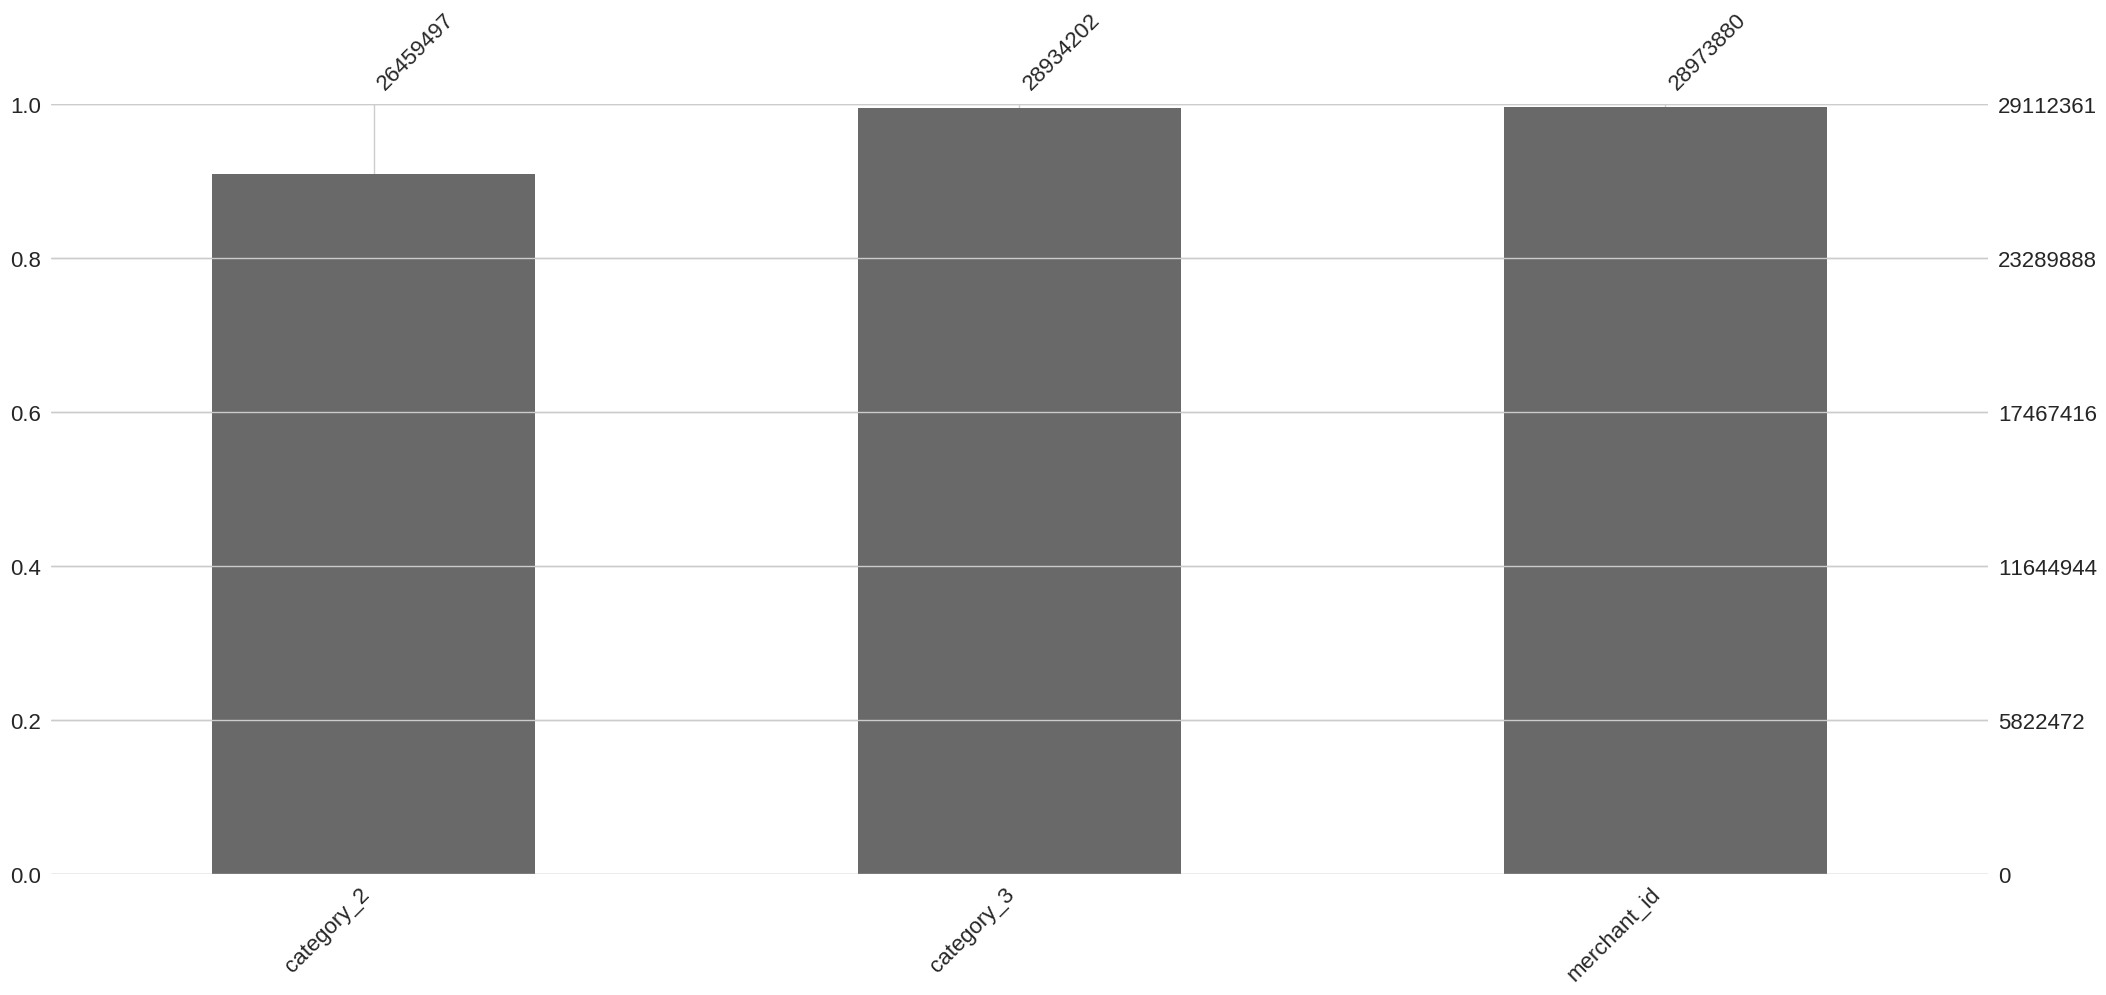

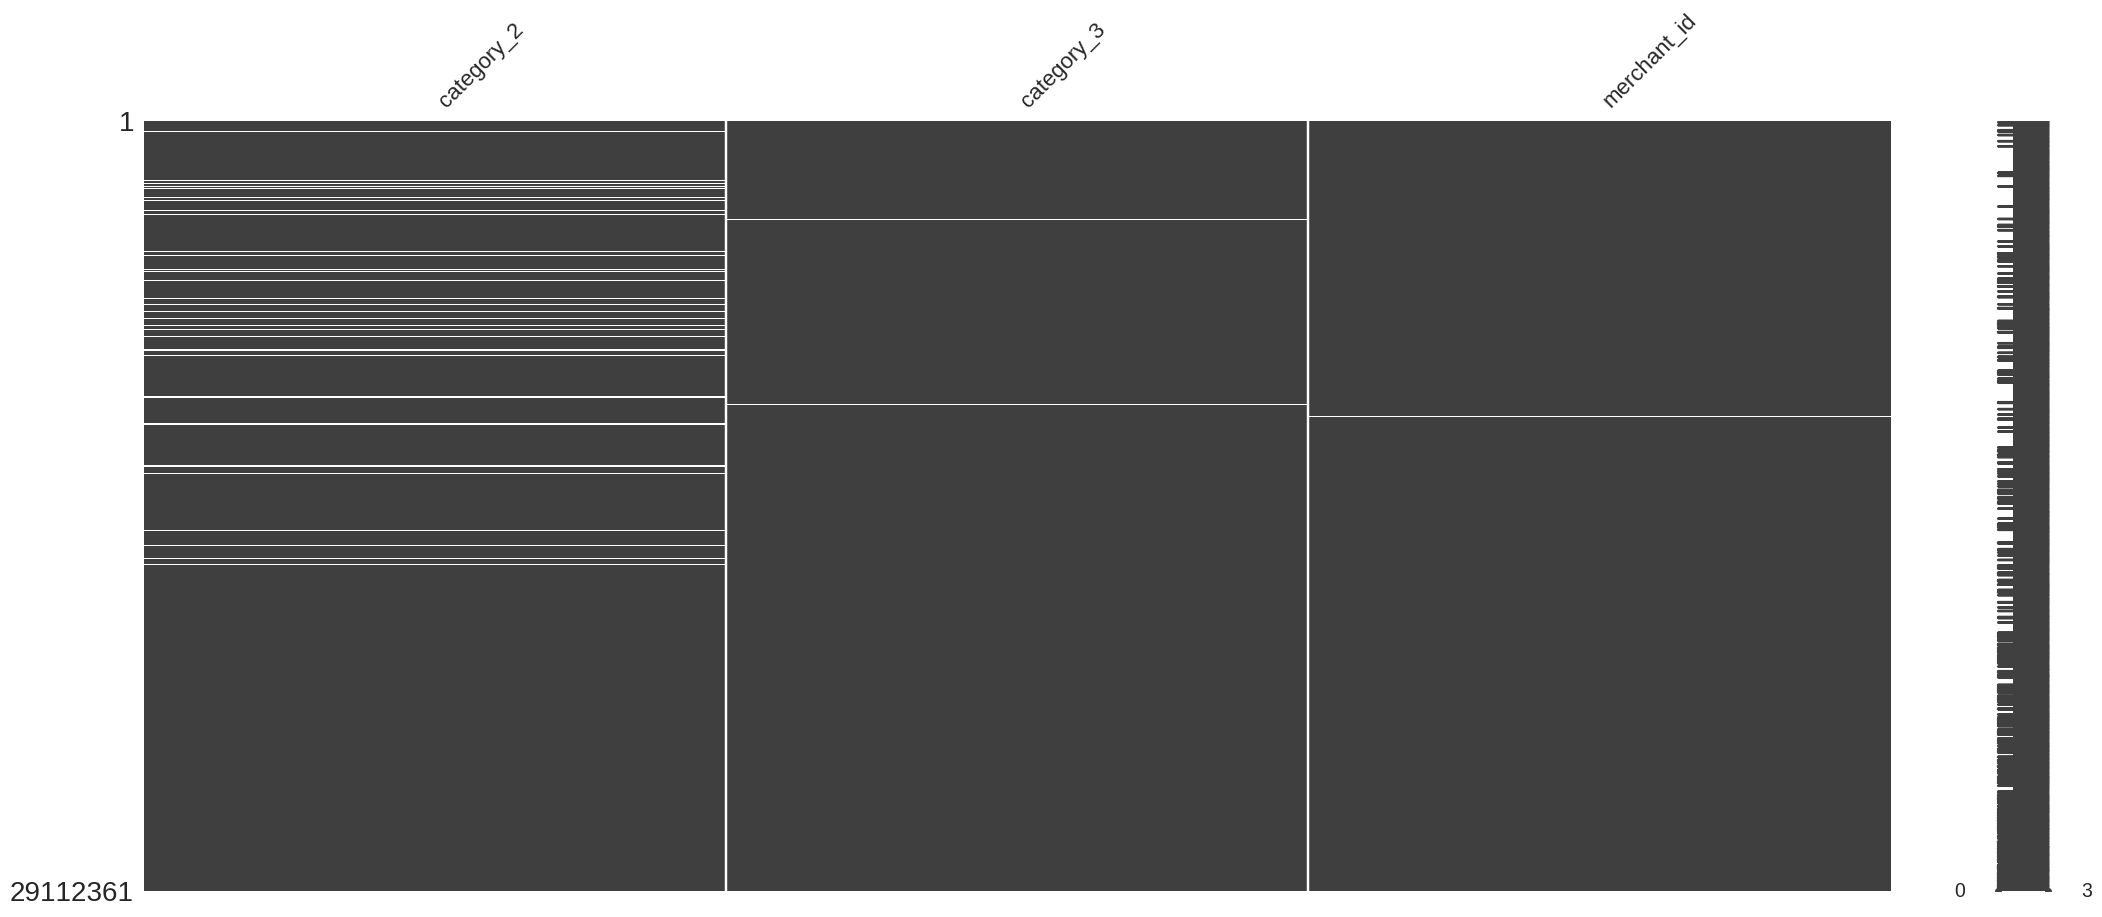

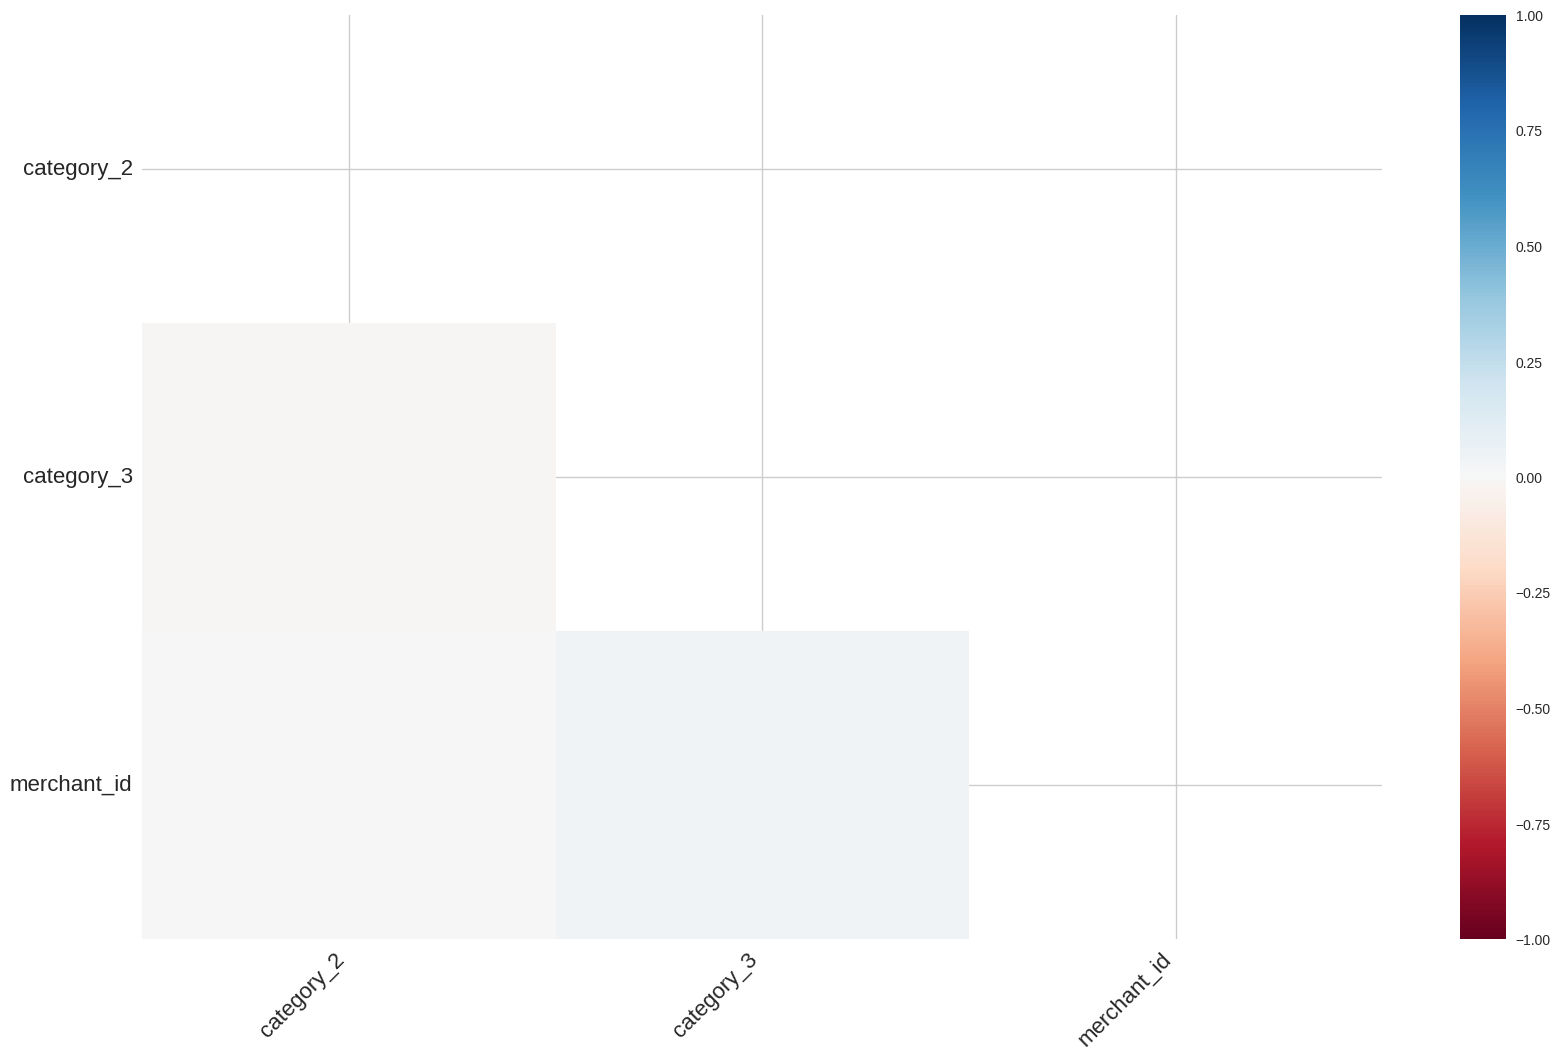

In [ ]:
# historical_transactions missing values visualization
msno.bar(historical_transactions[hist_tr_miss_col_names])
msno.matrix(historical_transactions[hist_tr_miss_col_names])
msno.heatmap(historical_transactions[hist_tr_miss_col_names])
#msno.dendrogram(historical_transactions[hist_tr_miss_col_names])

<Axes: >

<Axes: >

<Axes: >

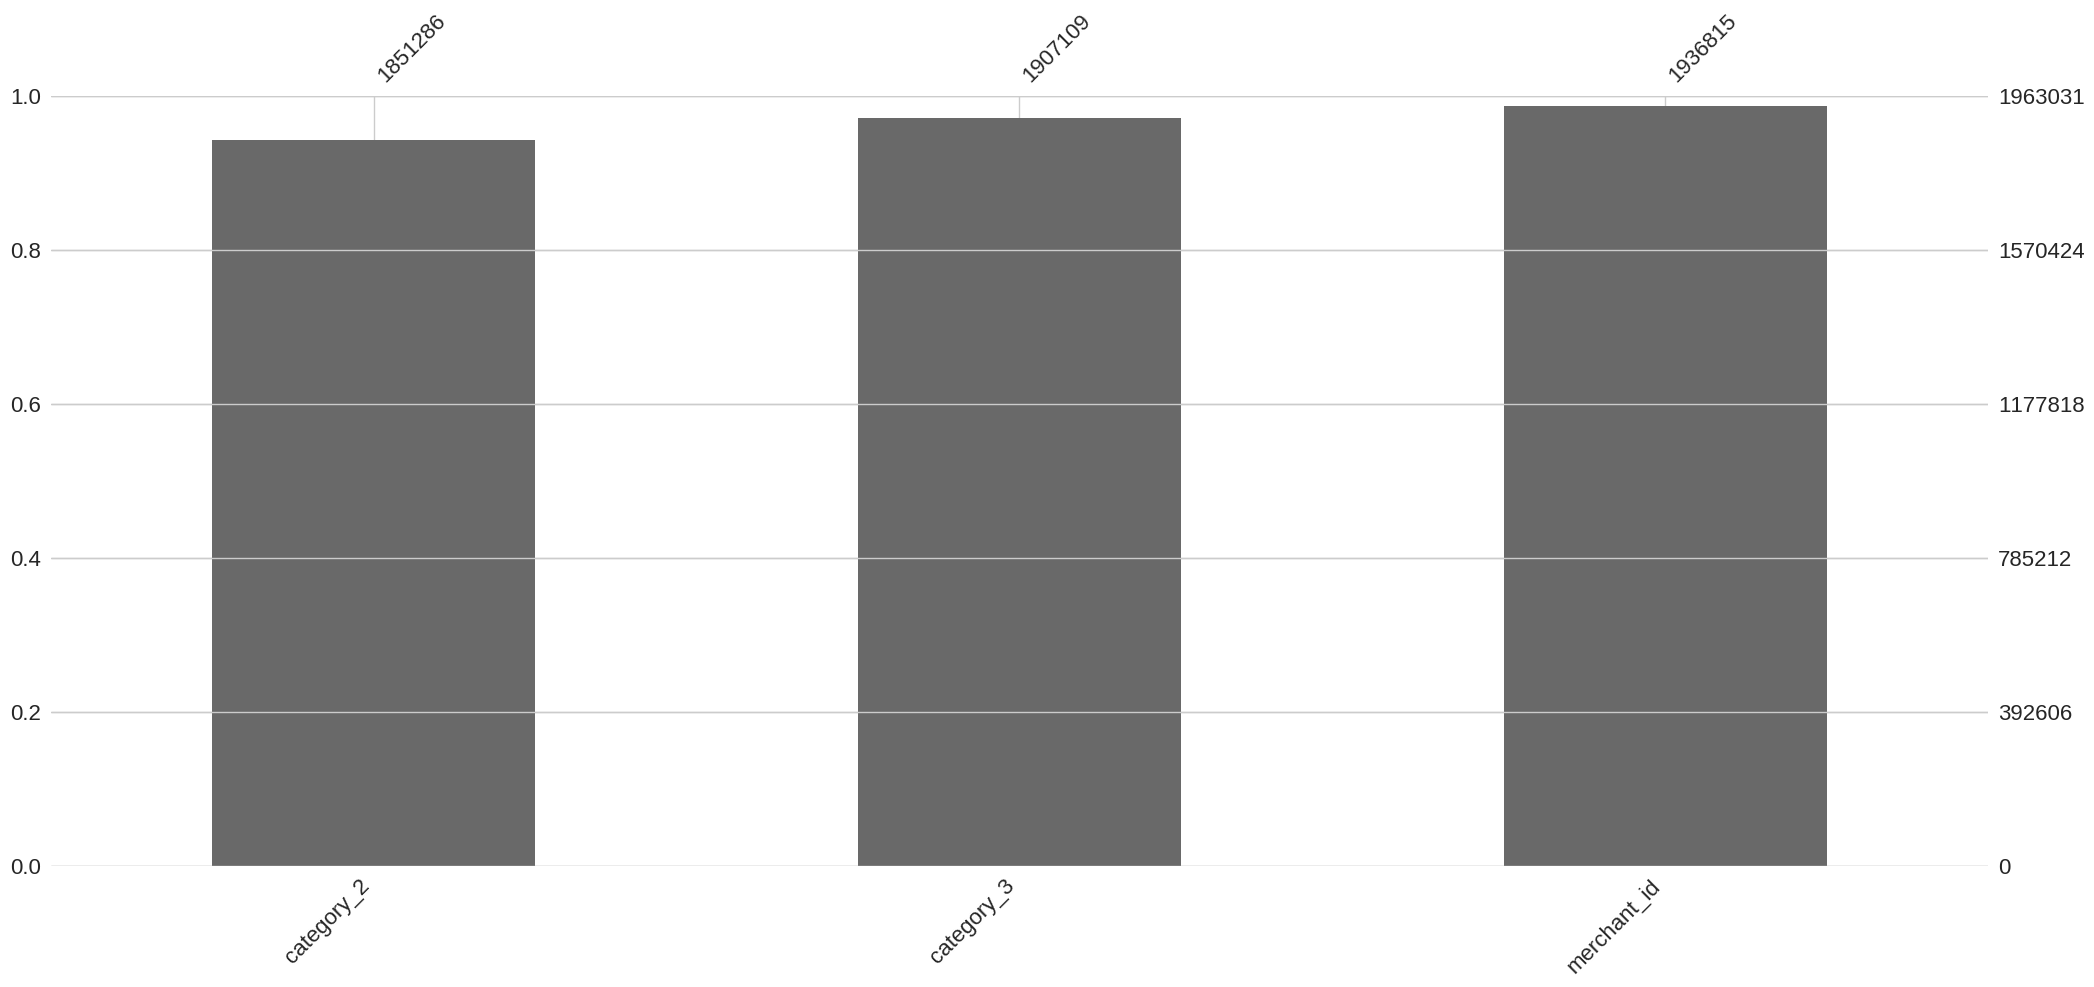

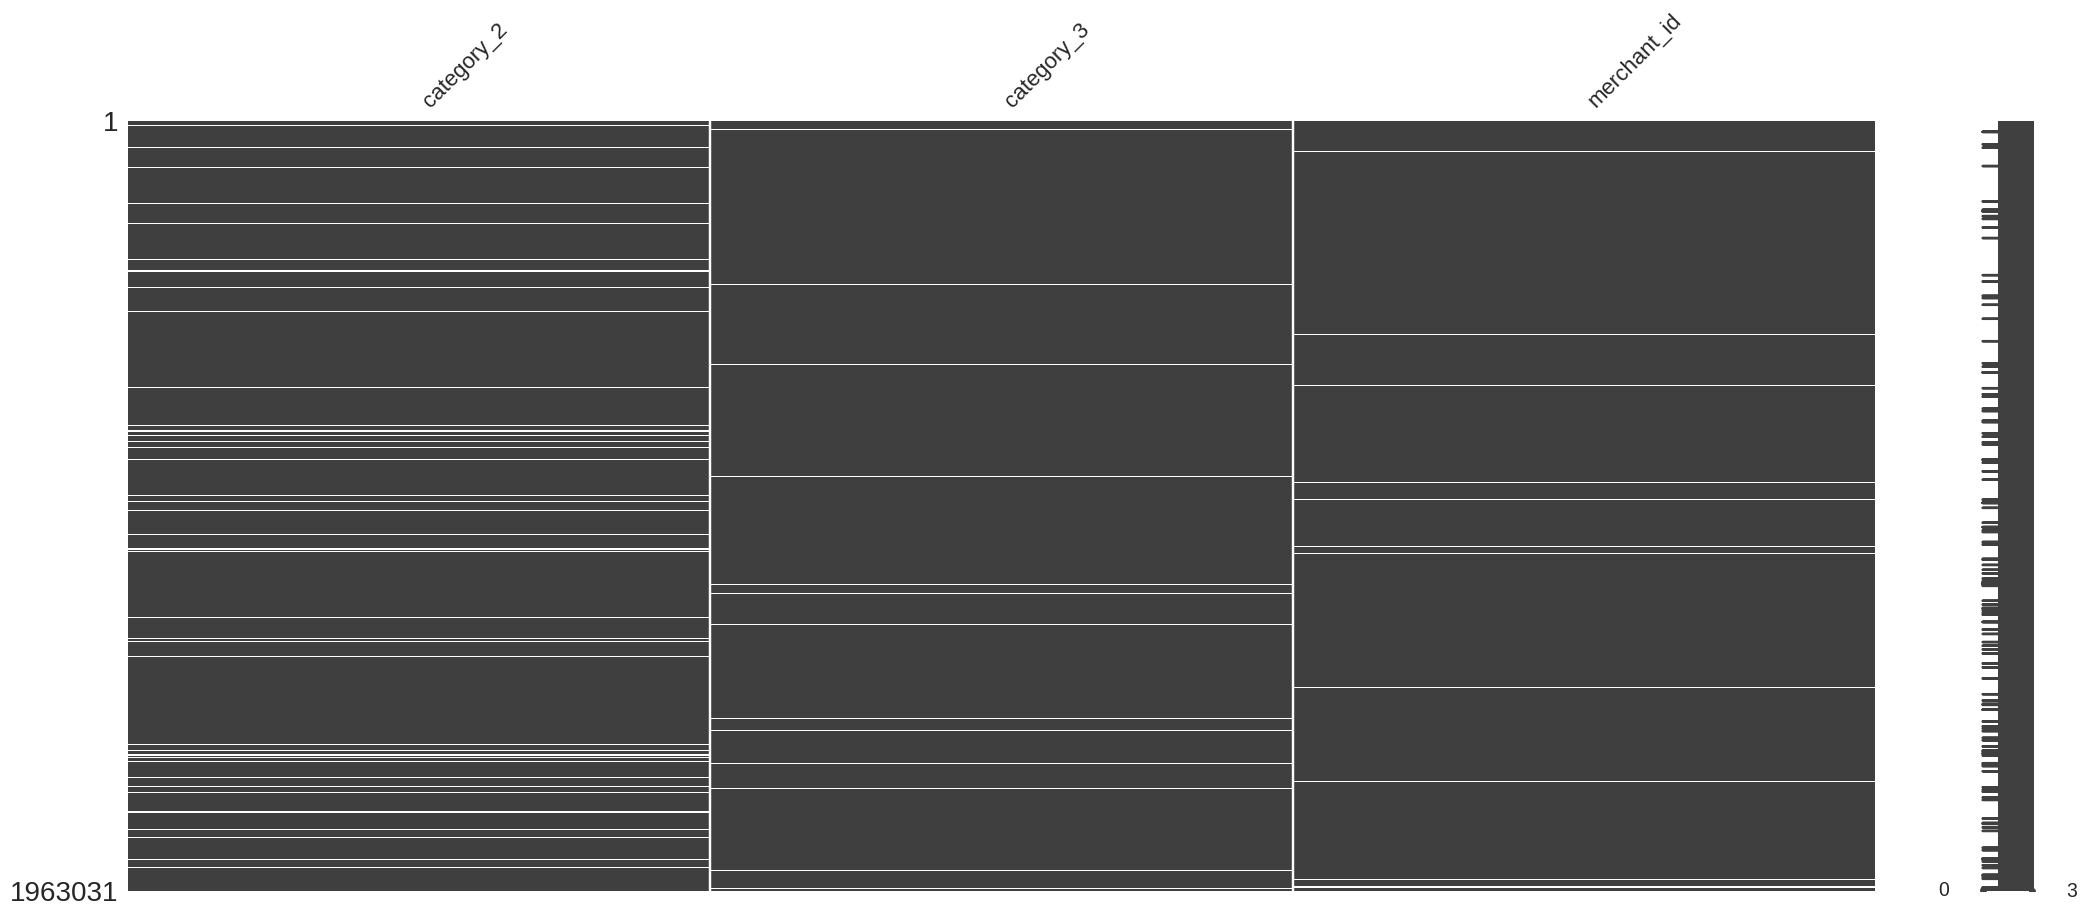

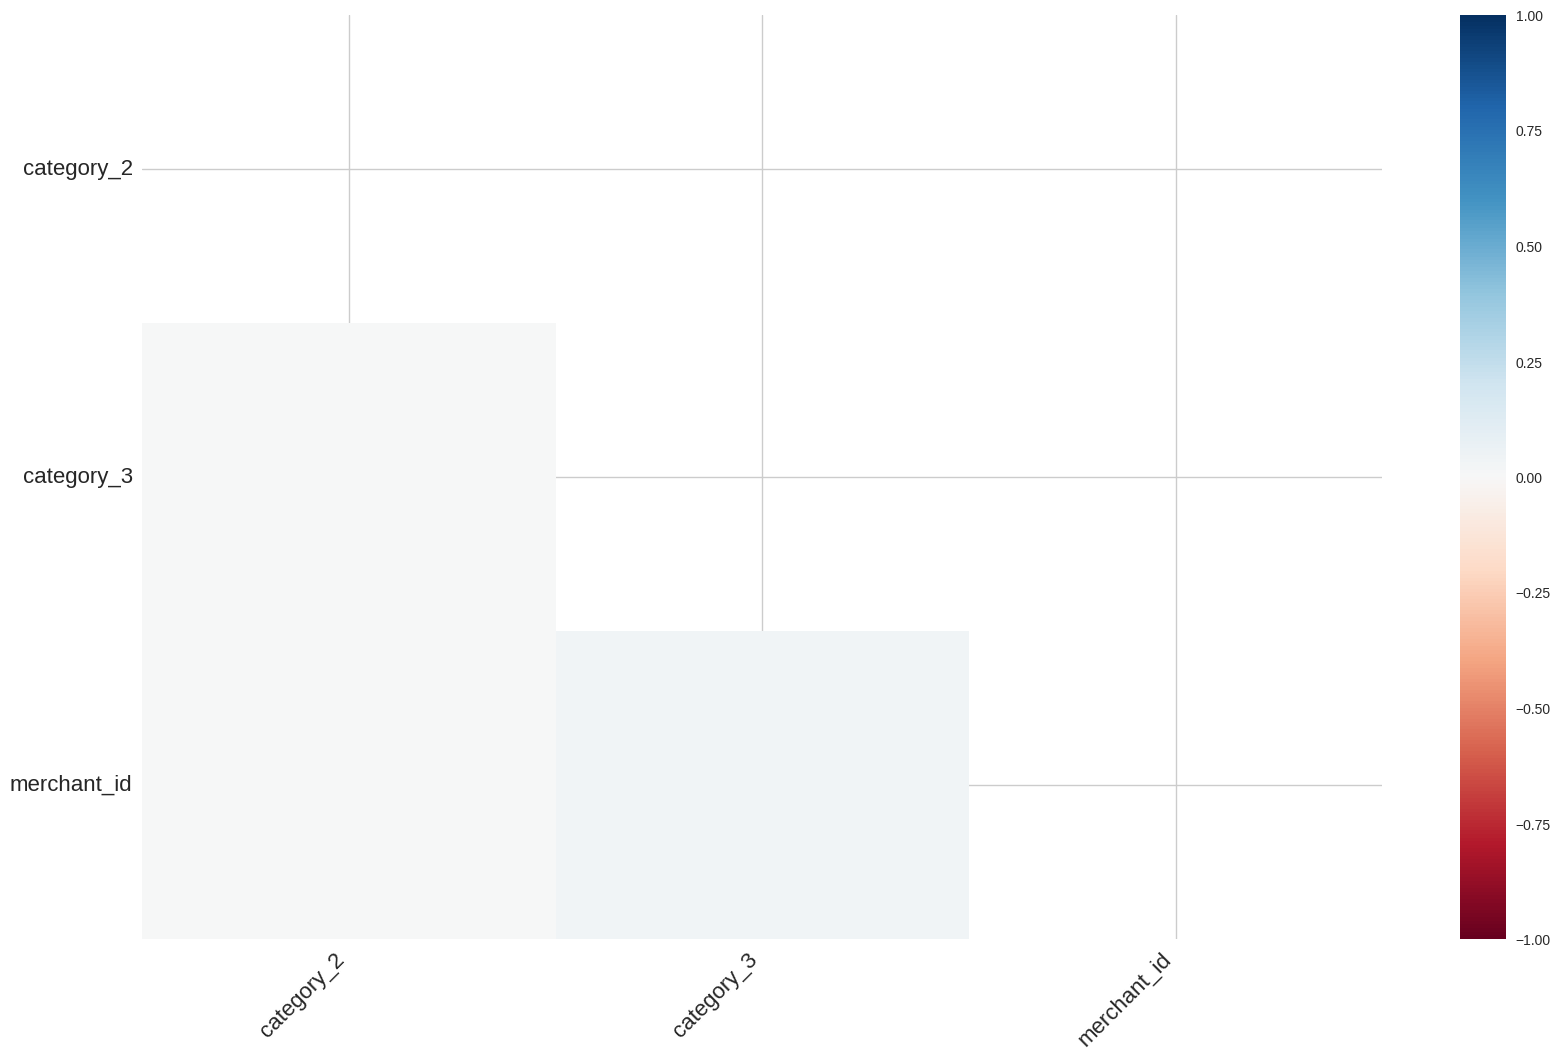

In [ ]:
# new_transactions missing values visualization
msno.bar(new_transactions[new_tr_miss_col_names])
msno.matrix(new_transactions[new_tr_miss_col_names])
msno.heatmap(new_transactions[new_tr_miss_col_names])

<Axes: >

<Axes: >

<Axes: >

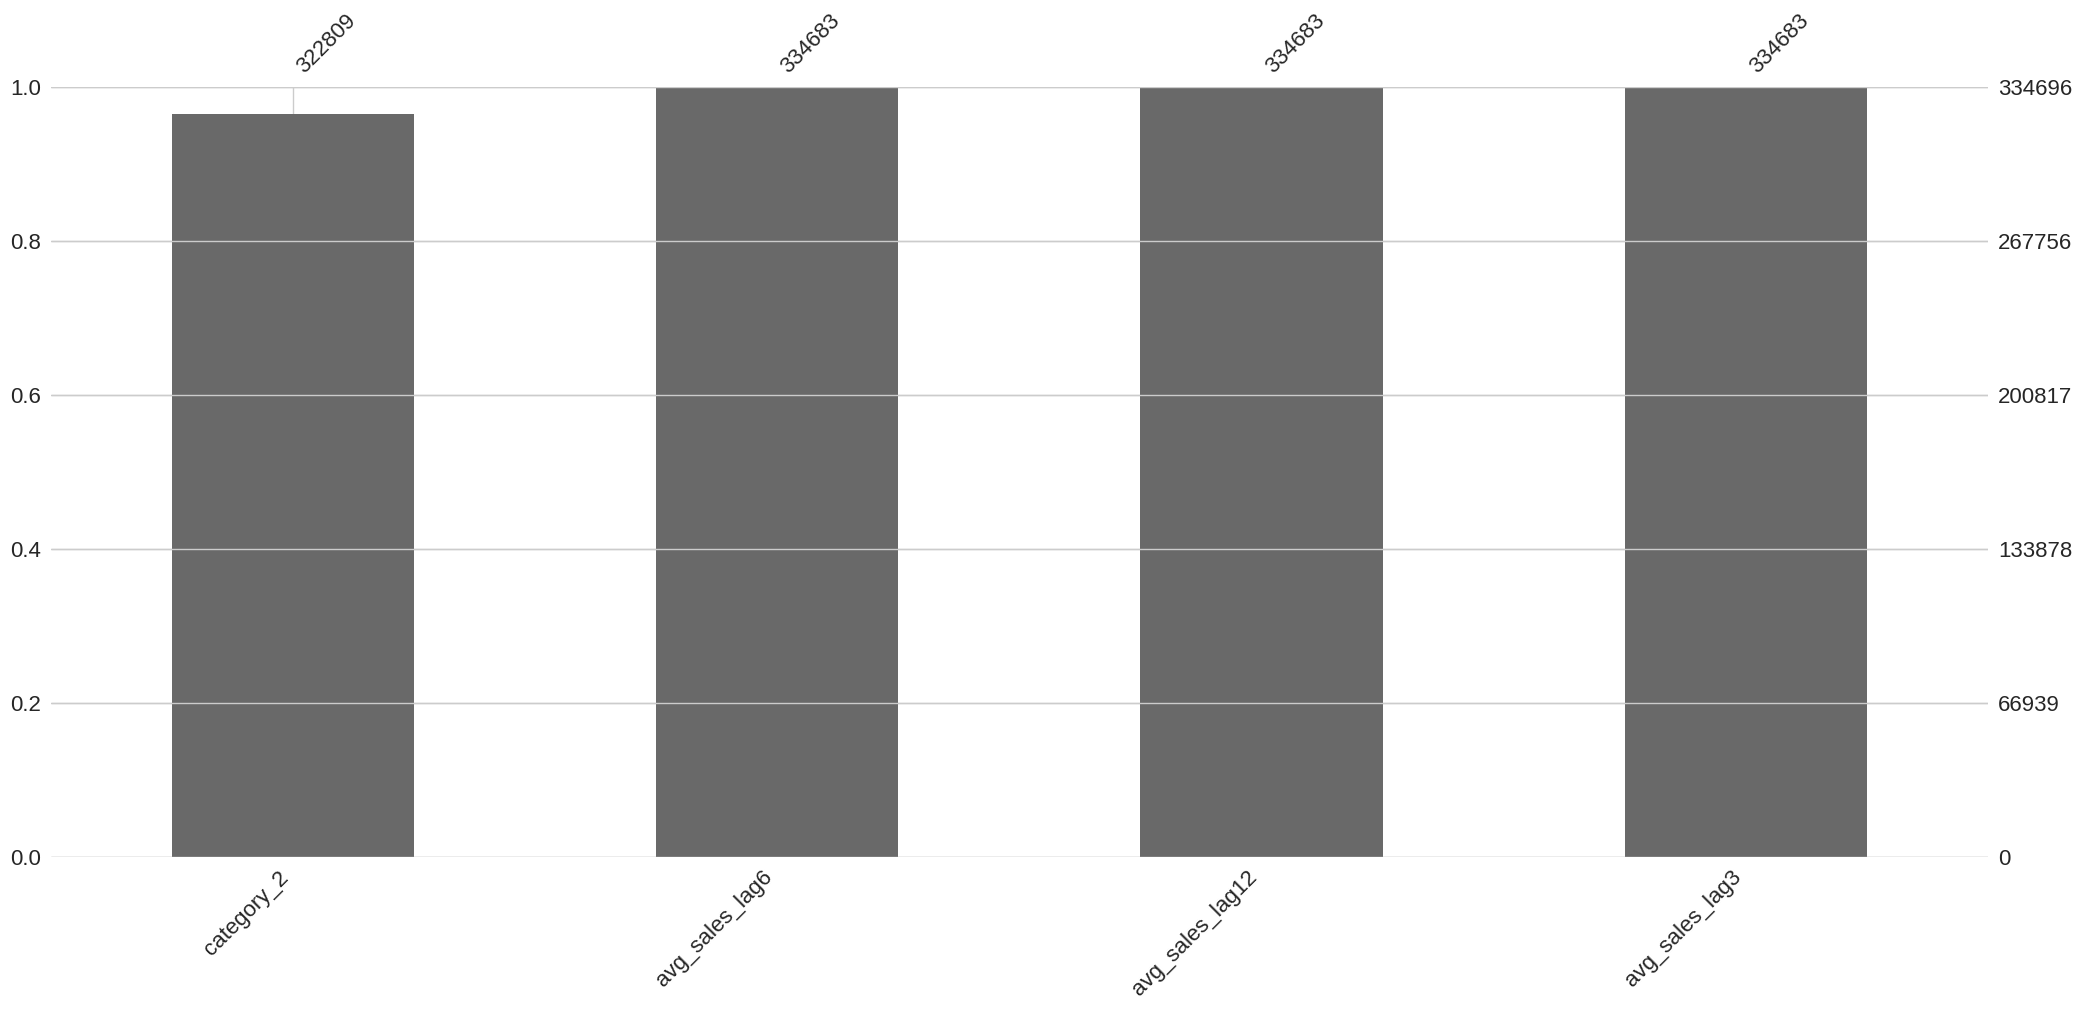

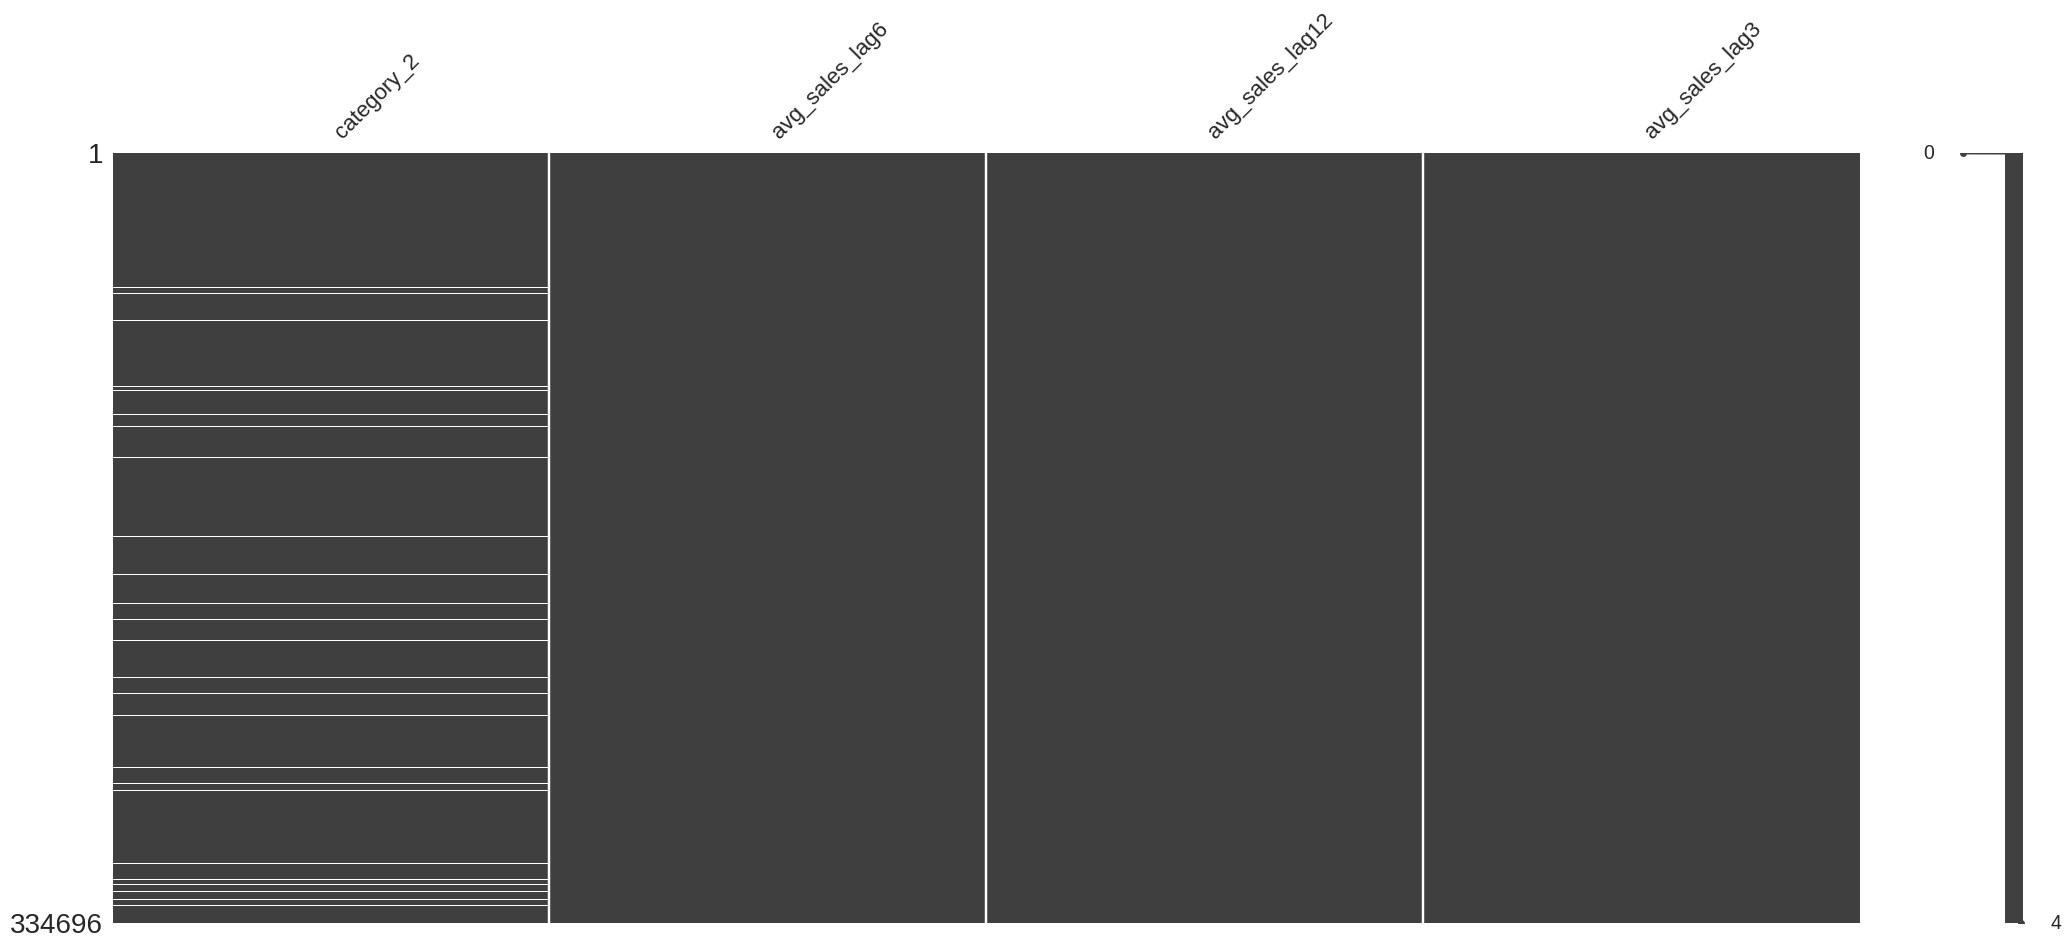

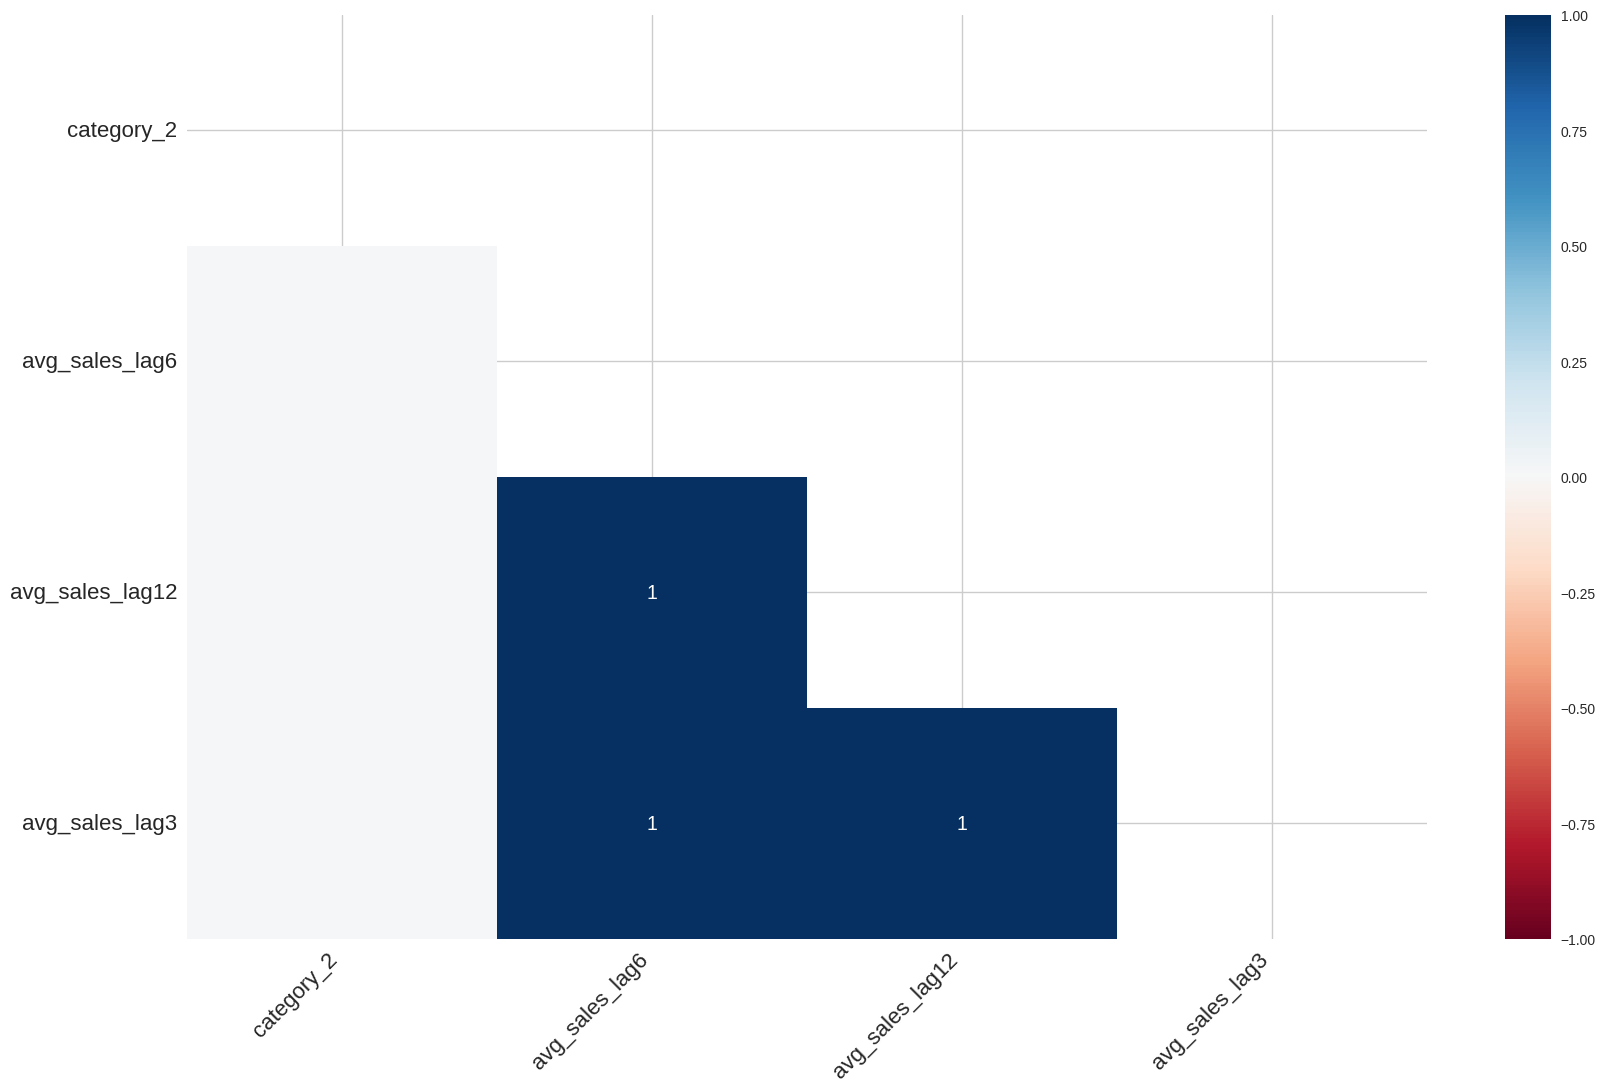

In [ ]:
# merchant missing values visualization
msno.bar(merchants[merch_miss_col_names])
msno.matrix(merchants[merch_miss_col_names])
msno.heatmap(merchants[merch_miss_col_names])


* From the above charts we noticed that there is no common pattern for missing values in "historical_transactions" & "new_transactions data",
* however The missing values can be MAR and be related to ceratin values of other features which can we be checked for or be MNAR and be related to some hidden latent variables that we don't observe in our dataset in both cases so it would be better if we use any multivariate imputation technique as KNN imputer or iterative imputer to avoid introducing any bias by imputing the missing values, however in sake of simplicity we will assume the missing values to be MCAR such that we can use simple imputation methods such as replacing by the mean for numerical features or by the most frequent for categorical features. We assume doing so will not have a severe impact as the missing values are in low numbers in comparison to the data volume and the highest percentage of missing values is under 10%, also we will later aggregate each user transactions together to have one record for each card_id so the imputation effect will be less.

* For "merchant" data we can notice that the following three features are missed together avg_sales_lag6, avg_sales_lag12, avg_sales_lag3 for 13 merchants so we can impute them with the mode value which will represent most repeated lag also this wont have bad impact given their extremely low number.

In [ ]:
# Changing the datatype of categorical features that have missing values to 'category' to be able to obtain most frequent value
for df in [historical_transactions,new_transactions]:
    df['category_2'] = df['category_2'].astype('category')
    df['category_3'] = df['category_3'].astype('category')
    df['merchant_id'] = df['merchant_id'].astype('category')


In [ ]:
# Printing most frequent values of categorical features that have missing values

print("\n Most repeated value of 'category_2' in historical_transactions is:",historical_transactions["category_2"].mode()[0]) # getting the most repeated category_2
print(historical_transactions["category_2"].value_counts()) # printing the values count of category_2

print("\n Most repeated value of 'category_3' in historical_transactions is:",historical_transactions["category_3"].mode()[0]) # getting the most repeated category_3
print(historical_transactions["category_3"].value_counts()) # printing the values count of category_3

print("\n Most repeated value of 'merchant_id' in historical_transactions is:",historical_transactions["merchant_id"].mode()[0]) # getting the most repeated merchant_id
print(historical_transactions["merchant_id"].value_counts()) # printing the values count of merchant_id

print("--------------------------------------------------------------------------------------")

print("\n Most repeated value of 'category_2' in new_transactions is:",new_transactions["category_2"].mode()[0]) # getting the most repeated category_2
print(new_transactions["category_2"].value_counts()) # printing the values count of category_2

print("\n Most repeated value of 'category_3' in new_transactions is:",new_transactions["category_3"].mode()[0]) # getting the most repeated category_3
print(new_transactions["category_3"].value_counts()) # printing the values count of category_3

print("\n Most repeated value of 'merchant_id' in new_transactions is:",new_transactions["merchant_id"].mode()[0]) # getting the most repeated merchant_id
print(new_transactions["merchant_id"].value_counts()) # printing the values count of merchant_id

print("--------------------------------------------------------------------------------------")

print("\n Most repeated value of 'category_2' in merchants is:",merchants["category_2"].mode()[0]) # getting the most repeated category_2
print(merchants["category_2"].value_counts()) # printing the values count of category_2


# Note:
# to get the most frequent value of categorical feature we can use either of below methods
# df["col"].value_counts().idxmax()
# or df["col"].mode()[0]


 Most repeated value of 'category_2' in historical_transactions is: 1.0
1.0    15177199
3.0     3911795
5.0     3725915
4.0     2618053
2.0     1026535
Name: category_2, dtype: int64

 Most repeated value of 'category_3' in historical_transactions is: A
A    15411747
B    11677522
C     1844933
Name: category_3, dtype: int64

 Most repeated value of 'merchant_id' in historical_transactions is: M_ID_00a6ca8a8a
M_ID_00a6ca8a8a    1115097
M_ID_e5374dabc0     428619
M_ID_9139332ccc     361385
M_ID_50f575c681     183894
M_ID_fc7d7969c3     177040
                    ...   
M_ID_4be25a7494          1
M_ID_ec5c44ccf3          1
M_ID_4be2f6c52d          1
M_ID_b55653ffc7          1
M_ID_896a73805d          1
Name: merchant_id, Length: 326311, dtype: int64
--------------------------------------------------------------------------------------

 Most repeated value of 'category_2' in new_transactions is: 1.0
1.0    1058242
3.0     289525
5.0     259266
4.0     178590
2.0      65663
Name: categor

From above analysis we obtained the most frequent values for the missing categorical features, we will use these values for imputation

* Most repeated value of 'category_2' in historical_transactions and new_transactions is: 1.0

* Most repeated value of 'category_3' in historical_transactions and new_transactions is: A

* Most repeated value of 'merchant_id' in historical_transactions and new_transactions is: M_ID_00a6ca8a8a

* Most repeated value of 'category_2' in merchants is: 1.0


In [ ]:
# Setting a dictionary of the coulmns containg nulls and the values to be added instead of the null (to be imputed by most frequent)
# it wont matter if we use historical_transactions or new_transactions to get most frequent value because as we have seen they have the same values.

values_to_fill_trns_NA = {"category_2": historical_transactions["category_2"].mode()[0], # 1.0
                     "category_3": historical_transactions["category_3"].mode()[0], # 'A'
                     "merchant_id": historical_transactions["merchant_id"].mode()[0]} # 'M_ID_00a6ca8a8a'

# Filling the null values in the transactions data by the predefined values
historical_transactions.fillna(value=values_to_fill_trns_NA, inplace=True)
new_transactions.fillna(value=values_to_fill_trns_NA, inplace=True)

# Merchant data missing values imputation
merchants['category_2'].fillna(merchants["category_2"].mode()[0], inplace=True) # it wont matter whcih dataset we get the most frequent category_2 value from as the three datasets have the same most repeated value as shown before
merchants['avg_sales_lag3'].fillna(merchants["avg_sales_lag3"].mode()[0], inplace=True) # most repeated lag value. we wont use mean value (~13.8) as it was much larger than the mode or median (~1)
merchants['avg_sales_lag6'].fillna(merchants["avg_sales_lag6"].mode()[0], inplace=True) # most repeated lag value. we wont use mean value (~21.7) as it was much larger than the mode or median (~1)
merchants['avg_sales_lag12'].fillna(merchants["avg_sales_lag12"].mode()[0], inplace=True) # most repeated lag value. we wont use mean value (~25.2) as it was much larger than the mode or median (~1)

# Count the total number of missing values for all features after imputation
print("The historical_transactions data contains a total of", historical_transactions.isnull().values.sum(), "missing values")
print("The new_transactions data contains a total of", new_transactions.isnull().values.sum(), "missing values")
print("The merchants data contains a total of", merchants.isnull().values.sum(), "missing values")

/tmp/ipykernel_33/3430151504.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  historical_transactions.fillna(value=values_to_fill_trns_NA, inplace=True)
/tmp/ipykernel_33/3430151504.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_transactions.fillna(value=values_to_fill_trns_NA, inplace=True)


The historical_transactions data contains a total of 0 missing values
The new_transactions data contains a total of 0 missing values
The merchants data contains a total of 0 missing values


## Duplicate Values Check

In [ ]:
# Userscore data duplicates check
userscore_dupl_rows = userscore.duplicated().sum() # checking for identical duplicate rows
userscore_dupl_card_id = userscore.duplicated(subset=['card_id']).sum() # checking for duplicate card_ids with different values which will represent inconsistency
# userscore.duplicated()[userscore.duplicated() == True]

print("There are {} duplicated identical rows in userscore data".format(userscore_dupl_rows))
print("There are {} duplicated card_ids in userscore data".format(userscore_dupl_card_id))

There are 0 duplicated identical rows in userscore data
There are 0 duplicated card_ids in userscore data


In [ ]:
# Transactions data duplicates check
hist_trns_dupl_rows = historical_transactions.duplicated().sum() # checking for identical duplicate rows
new_trns_dupl_rows = new_transactions.duplicated().sum() # checking for identical duplicate rows

# we wont check for duplicate rows on ids as its expected as each card_id with its related different ids will be repeated due to multiple different transactions

print("There are {} duplicated identical transactions in histroical_transactions data".format(hist_trns_dupl_rows))
print("There are {} duplicated identical transactions in new_transactions data".format(new_trns_dupl_rows))

There are 0 duplicated identical transactions in histroical_transactions data
There are 0 duplicated identical transactions in new_transactions data


In [ ]:
# Merchants data duplicates check
merchants_dupl_rows = merchants.duplicated().sum() # checking for identical duplicate rows
merchants_dupl_ids = merchants.duplicated(subset=['merchant_id']).sum() # checking for duplicate merchant_ids only which can take different attributes which will represent "inconsistency" in the entries
merchants_dupl_collective_ids = merchants.duplicated(subset=['merchant_id', 'merchant_group_id', 'merchant_category_id', 'subsector_id', 'city_id', 'state_id']).sum() # checking for duplicate ids with different values which will represent "inconsistency" in the entries

print("There are {} duplicated identical rows in merchants data".format(merchants_dupl_rows))
print("There are {} duplicated merchant ids with different attributes in merchants data, these duplictes should be dropped to avoid inconsistency".format(merchants_dupl_ids))
print("There are {} duplicated collective merchant ids enrties with different attributes in merchants data, these duplictes should be dropped to avoid inconsistency".format(merchants_dupl_collective_ids))

# Merchants duplicated rows visualization
#merchants[merchants.duplicated(subset=['merchant_id', 'merchant_group_id', 'merchant_category_id', 'subsector_id', 'city_id', 'state_id']) == True]

# Merchants duplicated rows dropping
merchants.drop_duplicates(subset=['merchant_id', 'merchant_group_id', 'merchant_category_id', 'subsector_id', 'city_id', 'state_id'], inplace=True)

There are 0 duplicated identical rows in merchants data
There are 63 duplicated merchant ids with different attributes in merchants data, these duplictes should be dropped to avoid inconsistency
There are 51 duplicated collective merchant ids enrties with different attributes in merchants data, these duplictes should be dropped to avoid inconsistency


In [ ]:
# After we dropped duplicate collective merchant identifiers that have different features values we will check duplicated merchant_ids to see why there is duplicates and inconsistency
print("There are {} duplicated merchant ids with inconsistent merchants data".format(merchants.duplicated(subset=['merchant_id']).sum()))

There are 12 duplicated merchant ids with inconsistent merchants data


In [ ]:
# Visulaize the remaining inconsistent merchant data
merchants[merchants.duplicated(subset=['merchant_id'], keep=False)] # checking for duplicate merchant_ids only which can take different feature values

# By eyeballing we can notice that these merchant_ids can have 2 different merchant_group_id or merchant_category_id however the feature values are the same
# We dont know which entry to drop and which to keep,so when merging merchants data with transactions data we will need to use common ids to take the correct enrty and avoid introducing nulls

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
3392,M_ID_bd49e37dda,35,692,21,-0.057471,-0.057471,N,E,E,60.09,9.333333,3,104.82,13.800000,5,104.82,13.800000,5,N,51,16,1.0
3393,M_ID_bd49e37dda,4170,692,21,-0.057471,-0.057471,N,E,E,60.09,9.333333,3,104.82,13.800000,5,104.82,13.800000,5,N,51,16,1.0
4181,M_ID_ef233cff26,35,560,34,-0.047556,-0.057471,N,E,E,322.44,76.555556,3,817.53,162.055556,6,778.20,149.592593,9,Y,69,9,1.0
4182,M_ID_ef233cff26,28799,560,34,-0.047556,-0.057471,N,E,E,322.44,76.555556,3,817.53,162.055556,6,778.20,149.592593,9,Y,69,9,1.0
7584,M_ID_dbbf07ebf0,69462,278,37,-0.057471,-0.057471,N,E,E,52.08,45.333333,3,75.36,68.000000,6,82.95,70.450000,10,Y,17,22,4.0
7585,M_ID_dbbf07ebf0,35,278,37,-0.057471,-0.057471,N,E,E,52.08,45.333333,3,75.36,68.000000,6,82.95,70.450000,10,Y,17,22,4.0
29464,M_ID_30340088f2,3318,544,29,-0.057471,-0.057471,N,E,E,1.00,1.000000,1,1.00,1.000000,1,1.00,1.000000,1,Y,69,9,1.0
29465,M_ID_30340088f2,35,544,29,-0.057471,-0.057471,N,E,E,1.00,1.000000,1,1.00,1.000000,1,1.00,1.000000,1,Y,69,9,1.0
47803,M_ID_645a6af169,35926,68,27,-0.057471,-0.057471,N,E,E,1.69,0.791667,3,2.62,1.812500,6,2.30,1.458333,12,N,94,19,3.0
47804,M_ID_645a6af169,19140,87,27,-0.057471,-0.057471,N,E,E,0.89,1.111111,3,1.54,1.555556,6,1.55,2.000000,12,N,29,15,1.0


In [ ]:
# Later it was noticed that there other inconsisent values in the features as well
# we need to check how many transactions are done with these 12 noisy merchants to assess their removal possibility
noisy_merchant_ids = merchants[merchants.duplicated(subset=['merchant_id'], keep=False)]['merchant_id']


# number of transactions done with the 12 noisy merchants
noisy_merch_hist_trns = historical_transactions[historical_transactions['merchant_id'].isin(noisy_merchant_ids)]['merchant_id']
noisy_merch_new_trns = new_transactions[new_transactions['merchant_id'].isin(noisy_merchant_ids)]['merchant_id']

print("There are {} transactions done with the 12 noisy merchants in historical data".format(noisy_merch_hist_trns.count()))
print("There are {} transactions done with the 12 noisy merchants in new transactions data".format(noisy_merch_new_trns.count()))

# Since transactions are small in number we assume it safe to drop them
#Dropping transactions with noisy merchants
#historical_transactions = historical_transactions.drop(noisy_merch_hist_trns.index)
#new_transactions = new_transactions.drop(noisy_merch_new_trns.index)


# Or we can drop inconsistent duplicate merchants ids entries instead of dropping the transactions
#merchants.drop_duplicates(subset=['merchant_id'], inplace=True)
# Recheck duplicates count
#print("There are {} duplicated merchant ids with inconsistent merchants data".format(merchants.duplicated(subset=['merchant_id']).sum()))

There are 12236 transactions done with the 12 noisy merchants in historical data
There are 1618 transactions done with the 12 noisy merchants in new transactions data


In [ ]:
#historical_transactions[historical_transactions['merchant_id'].isin(noisy_merchant_ids)]["card_id"]

# **Data Preprocessing**

## "Userscore" Data Preprocessing

In [ ]:
# Data dictionary - features explaination of userscore.csv file
explain_userscore = pd.read_excel('/kaggle/input/cisc839-a1-data-dictionary/Data Dictionary.xlsx', sheet_name='userscore', header =2)
explain_userscore

,Columns,Description
0,card_id,Unique card identifier
1,first_active_month,"'YYYY-MM', month of first purchase"
2,feature_1,Anonymized card categorical feature
3,feature_2,Anonymized card categorical feature
4,feature_3,Anonymized card categorical feature
5,target,Loyalty numerical score calculated 2 months af...


In [ ]:
# Checking card_id counts consisitency

print("number of unique card_ids in userscore:", userscore["card_id"].nunique()) # 201,917 (cards that we have data and loyalty score for them)
print("number of unique card_ids in historical_transactions:", historical_transactions['card_id'].nunique()) # 325,540
print("number of unique card_ids in new_transactions:", new_transactions['card_id'].nunique()) # 290,001
print("number of unique card_ids in historical_transactions and new_transactions combined:",len(np.unique(np.concatenate((historical_transactions['card_id'], new_transactions['card_id']), axis =0)))) # 325,540

# since number of unique card_ids in userscore is less than that in historical_transcation & new_transactions concatenated
# this means that there are transactions for card_ids that we don't have info for in the userscore.csv file, these card_ids will be removed when we merge the datasets.

number of unique card_ids in userscore: 201917
number of unique card_ids in historical_transactions: 325540
number of unique card_ids in new_transactions: 290001
number of unique card_ids in historical_transactions and new_transactions combined: 325540


<Figure size 1200x800 with 0 Axes>

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Histogram of Loyalty Score')

Text(0.5, 0, 'Loyalty Score')

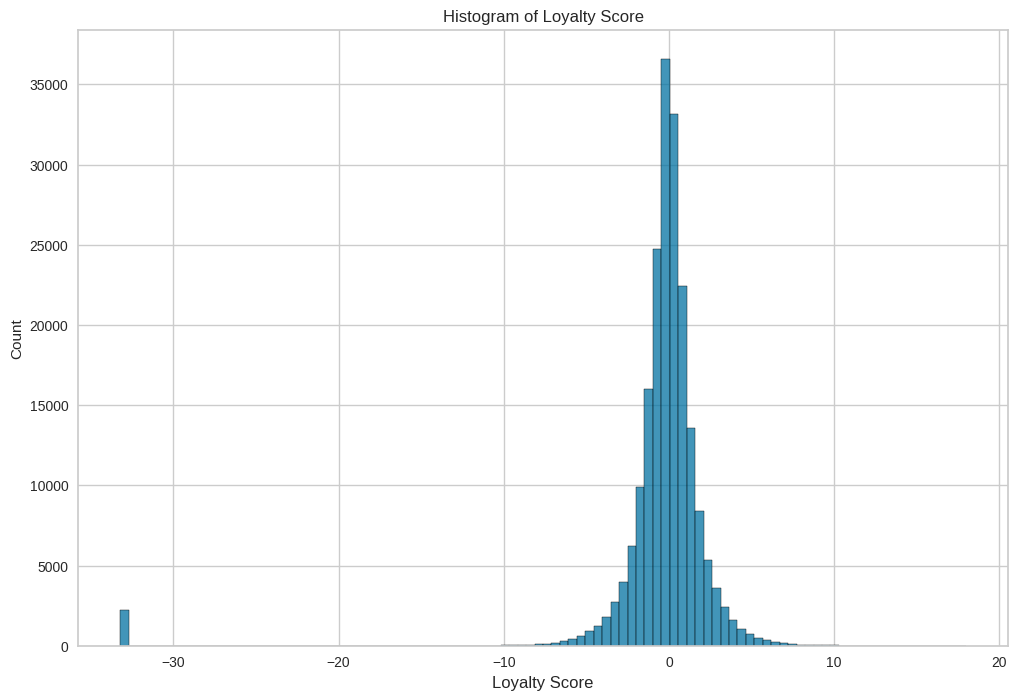

In [ ]:
# Checking the loyalty score histogram, clearly we will see that there are outliers

plt.figure(figsize=(12,8))
sns.histplot(userscore["score"].values, bins=100)
plt.title("Histogram of Loyalty Score")
plt.xlabel('Loyalty Score', fontsize=12)
plt.show()

In [ ]:
# Checking number of outliers
num_outliers = (userscore['score'] < -30).sum()
print("There are {} outlier cards in userscore data which will be excluded".format(num_outliers)) # 2207

# Dropping card_ids that have a score less than -30 which are representing outliers
# We will drop these outliers as the impact regression models severly
score_outliers_index = userscore[userscore['score'] < -30].index # indcies of oultliers entries in userscore df
userscore.drop(score_outliers_index, inplace=True) # dropping the outliers

# We can make a new feature to say whether this card_id is outlier or not and make another model using theses outliers but for now they are dropped
#userscore['outliers'] = 0
#userscore.loc[userscore['score'] < -30, 'outliers'] = 1
#userscore['outliers'].value_counts()

There are 2207 outlier cards in userscore data which will be excluded


In [ ]:
# As mentioned in data dictionary features 1,2,3 are anonymized categorical features so will convert them to categorical

userscore['feature_1'] = userscore['feature_1'].astype('category')
userscore['feature_2'] = userscore['feature_2'].astype('category')
userscore['feature_3'] = userscore['feature_3'].astype('category')

In [ ]:
#print(max(pd.to_datetime(historical_transactions["purchase_date"]))) # Timestamp('2018-02-28 23:59:51')
#max(pd.to_datetime(new_transactions["purchase_date"])) # Timestamp('2018-04-30 23:59:59')

* In order to make use of the "first_active_month" feature we need to first convert it to a datetime format that can be understood by pandas to avoid OutOfBoundsDatetime error
* After conversion, this absolute date value is useless on its own, however we can create new feature which can represent for how many days this card_id has been issued
* To calculate this card_id age value we need a reference date to subtract the issuing data from (first_active_month)
* We chose this refrence date to be the last (most recent) issuing data in userscore data, such that the last issued card will have an age of 0 days


In [ ]:

def date_formatting(string_date):
    """Given string datatime format of %b-%y eg. Jun-17 will convert it to %Y-%m format i.e 2017-06 to be able to use it later using pandas """
    return datetime.strftime(datetime.strptime(string_date,'%b-%y'),'%Y-%m')


userscore['first_active_month'] = userscore['first_active_month'].apply(lambda str_date: date_formatting(str_date)) # axis = 1 or 'columns': apply function to each row.
userscore['first_active_month'] = pd.to_datetime(userscore['first_active_month']) # converting first_active_date to datetime

userscore.head()

# Feature Creation
last_card_issuing_date = max(userscore['first_active_month'].dt.date) # maximum date
first_card_issuing_date = min(userscore['first_active_month'].dt.date) # minimum date

print("\n")
print(" Last card issuing date is:",last_card_issuing_date)
print(" First card issuing date is:",first_card_issuing_date)
print("\n")

def card_rel_age_days(timedelta_obj):
    """ returns the number of days from timedelta object"""
    return timedelta_obj.days

userscore['card_relative_age'] = last_card_issuing_date - userscore['first_active_month'].dt.date
userscore['card_relative_age'] = userscore['card_relative_age'].apply(lambda timedelta_obj: card_rel_age_days(timedelta_obj)) # card_id age in days

# Drop the "first_active_month" as we extracted its information in the new created feature "card_relative_age"
userscore = userscore.drop('first_active_month', axis=1)
userscore.head()

,card_id,first_active_month,feature_1,feature_2,feature_3,score
0,C_ID_92a2005557,2017-06-01,5,2,1,-0.820283
1,C_ID_3d0044924f,2017-01-01,4,1,0,0.392913
2,C_ID_d639edf6cd,2016-08-01,2,2,0,0.688056
3,C_ID_186d6a6901,2017-09-01,4,3,0,0.142495
4,C_ID_cdbd2c0db2,2017-11-01,1,3,0,-0.159749




 Last card issuing date is: 2018-02-01
 First card issuing date is: 2011-11-01




,card_id,feature_1,feature_2,feature_3,score,card_relative_age
0,C_ID_92a2005557,5,2,1,-0.820283,245
1,C_ID_3d0044924f,4,1,0,0.392913,396
2,C_ID_d639edf6cd,2,2,0,0.688056,549
3,C_ID_186d6a6901,4,3,0,0.142495,153
4,C_ID_cdbd2c0db2,1,3,0,-0.159749,92


## "merchants" Data Preprocessing

In [ ]:
# Data dictionary - features explaination of merchant data file
explain_merchants = pd.read_excel('/kaggle/input/cisc839-a1-data-dictionary/Data Dictionary.xlsx', sheet_name='merchant', header =2)
explain_merchants

,Columns,Description
0,merchant_id,Unique merchant identifier
1,merchant_group_id,Merchant group (anonymized )
2,merchant_category_id,Unique identifier for merchant category (anony...
3,subsector_id,Merchant category group (anonymized )
4,numerical_1,anonymized measure
5,numerical_2,anonymized measure
6,category_1,anonymized category
7,most_recent_sales_range,Range of revenue (monetary units) in last acti...
8,most_recent_purchases_range,Range of quantity of transactions in last acti...
9,avg_sales_lag3,Monthly average of revenue in last 3 months di...


In [ ]:
# Rechecking merchnat datatypes for proper conversions
merchants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334645 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334645 non-null  object 
 1   merchant_group_id            334645 non-null  int64  
 2   merchant_category_id         334645 non-null  int64  
 3   subsector_id                 334645 non-null  int64  
 4   numerical_1                  334645 non-null  float64
 5   numerical_2                  334645 non-null  float64
 6   category_1                   334645 non-null  object 
 7   most_recent_sales_range      334645 non-null  object 
 8   most_recent_purchases_range  334645 non-null  object 
 9   avg_sales_lag3               334645 non-null  float64
 10  avg_purchases_lag3           334645 non-null  float64
 11  active_months_lag3           334645 non-null  int64  
 12  avg_sales_lag6               334645 non-null  float64
 13 

In [ ]:
# Adjust data types of feature in "historical" and "new" transactions
merchants['merchant_id'] = merchants['merchant_id'].astype('category')
merchants['merchant_group_id'] = merchants['merchant_group_id'].astype('category')
merchants['merchant_category_id'] = merchants['merchant_category_id'].astype('category')
merchants['subsector_id'] = merchants['subsector_id'].astype('category')
merchants['category_1'] = merchants['category_1'].map({'Y':1, 'N':0})
merchants['most_recent_sales_range'] = merchants['most_recent_sales_range'].astype('category')
merchants['most_recent_purchases_range'] = merchants['most_recent_purchases_range'].astype('category')
merchants['category_4'] = merchants['category_4'].map({'Y':1, 'N':0})
merchants['city_id'] = merchants['city_id'].astype('category')
merchants['state_id'] = merchants['state_id'].astype('category')
merchants['category_2'] = merchants['category_2'].astype('category')

## "Historical" and "New" Transactions Data Preprocessing

In [ ]:
# data dictionary - features explaination of historical and new transactions data files
explain_historical = pd.read_excel('/kaggle/input/cisc839-a1-data-dictionary/Data Dictionary.xlsx', sheet_name='history', header =2)
explain_historical

,Columns,Description
0,card_id,Card identifier
1,month_lag,month lag to reference date
2,purchase_date,Purchase date
3,authorized_flag,"Y' if approved, 'N' if denied"
4,category_3,anonymized category
5,installments,number of installments of purchase
6,category_1,anonymized category
7,merchant_category_id,Merchant category identifier (anonymized )
8,subsector_id,Merchant category group identifier (anonymized )
9,merchant_id,Merchant identifier (anonymized)


In [ ]:
# Rechecking datatypes for proper conversions
historical_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
 #   Column                Dtype   
---  ------                -----   
 0   authorized_flag       object  
 1   card_id               object  
 2   city_id               int64   
 3   category_1            object  
 4   installments          int64   
 5   category_3            category
 6   merchant_category_id  int64   
 7   merchant_id           category
 8   month_lag             int64   
 9   purchase_amount       float64 
 10  purchase_date         object  
 11  category_2            category
 12  state_id              int64   
 13  subsector_id          int64   
dtypes: category(3), float64(1), int64(6), object(4)
memory usage: 2.6+ GB


In [ ]:
# Adjust data types of feature in "historical" and "new" transactions
for df in [historical_transactions,new_transactions]:
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['city_id'] = df['city_id'].astype('category')
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0})
    df['merchant_category_id'] = df['merchant_category_id'].astype('category')
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['state_id'] = df['state_id'].astype('category')
    df['subsector_id'] = df['subsector_id'].astype('category')

### Some chosen features values analysis

#### "installments" Feature analysis

* When we checked values of 'installments' feature which is number of installments of purchase, we found strange special values of -1 and 999
* These numbers for sure are not representing the real supposed feature value so we should decide how to treat them either by dropping or by replacing.
* These special values may have meaning that we dont know or they can be just a placeholder for missing data
* Since these transactions may have important information we will decide to replace these special values by the mean value of the installments instead of dropping them

In [ ]:
historical_transactions['installments'].value_counts() # special values -1,999
new_transactions['installments'].value_counts() # special values -1,999

 0      15411747
 1      11677522
 2        666416
 3        538207
 4        179525
-1        178159
 6        132634
 10       118827
 5        116090
 12        55064
 8         20474
 7         10906
 9          5772
 11          830
 999         188
Name: installments, dtype: int64

 0      922244
 1      836178
-1       55922
 2       54729
 3       44750
 4       14815
 6       10389
 5        9296
 10       8899
 12       2850
 8        1555
 7         863
 9         478
 11         61
 999         2
Name: installments, dtype: int64

* We will replace the special values of -1 and 999 in historical and new transactions by the mean value
* We will calculate the mean of the installments feature in each dataset independently
* In order to calculate this mean value we will have first to remove these special values from the data


In [ ]:

special_hist_installments_index = historical_transactions[(historical_transactions.installments == -1) | (historical_transactions.installments == 999)].index # indcies of installments values of -1 or 999 in historical transactions
special_new_installments_index = new_transactions[(new_transactions.installments == -1) | (new_transactions.installments == 999)].index # indcies of installments values of -1 or 999 in new transactions

hist_trns_wo_special = historical_transactions.drop(special_hist_installments_index) # historical transactions without the special values of the installment feature
new_trns_wo_special = new_transactions.drop(special_new_installments_index) # new transactions without the special values of the installment feature

mean_installments_hist_trns = hist_trns_wo_special['installments'].mean() # mean value of installments in case of historical transactions
mean_installments_new_trns = new_trns_wo_special['installments'].mean() # mean value of installments in case of new transactions

print("Mean value of installments in case of historical transactions is {}, to be used to replace special values of -1 and 999".format(mean_installments_hist_trns))
print("Mean value of installments in case of new transactions is {}, to be used to replace special values of -1 and 999".format(mean_installments_new_trns))

# replacing -1 and 999 of "installments" feature in historical and new transactions by their corresponding mean value
historical_transactions['installments'] = historical_transactions['installments'].replace([-1,999], mean_installments_hist_trns)
new_transactions['installments'] = new_transactions['installments'].replace([-1,999], mean_installments_new_trns)


Mean value of installments in case of historical transactions is 0.6521590471339372, to be used to replace special values of -1 and 999
Mean value of installments in case of new transactions is 0.7312667826189092, to be used to replace special values of -1 and 999


#### "authorized_flag" Feature analysis

<Axes: title={'center': 'historical transactions authorized_flag value counts'}>

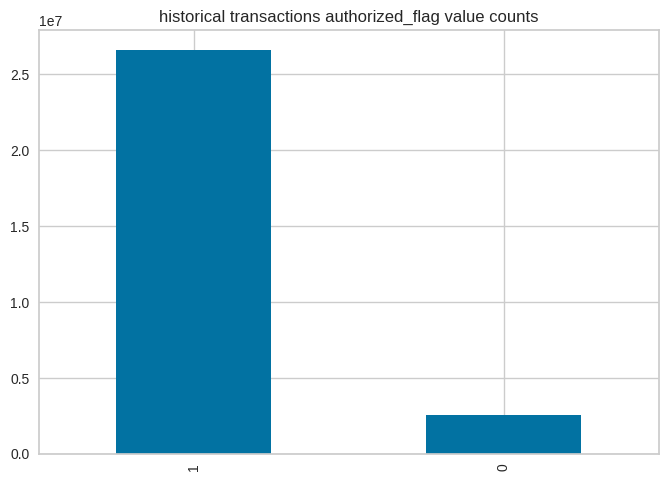

In [ ]:
# In historical_transactions we can see that we have authorized and unauthorized transactions
historical_transactions['authorized_flag'].value_counts().plot(kind='bar', title='historical transactions authorized_flag value counts', )

<Axes: title={'center': 'new transactions authorized_flag value counts'}>

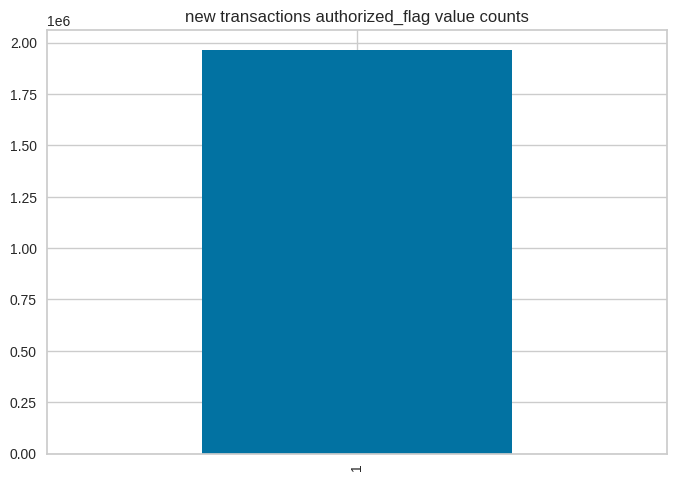

In [ ]:
# In new_transactions we only have authorized transactions
new_transactions['authorized_flag'].value_counts().plot(kind='bar', title='new transactions authorized_flag value counts')

Before proceeding any further we will have 2 cases:

* Case 1: We'll merge the merchnats data with the transactions data
        - when we procceded with this case the merchants data is noisy and introduces alot of missing values and inconsistent values in the data
        - we decided that we can tolerate not having some additional features in sake of data quality and integrity

* Case 2: We'll assume that merchants data has no influence on user score and will not use the merchants.csv file and this is what we chose as other option introduces a lot of noise

In case of case 1: merging of transactions with merchants data
* When we tried merging the datasets using how='left' we found that there are alot of null values introduced in merchnats attributes that are beyound imputation
* These would suggest that the some of the merging_ids used for merging exist only in the transactions data and are not found in the merchants data
* So we'll have 2 options either choose how='inner' to get the common entries on the expense of losing some card_ids from the data or not to use merchnats data at all
* We'll first assess the behaviour of using the inner join but if time allows we will try experimenting the other case of not using the merchants data


In [ ]:
# Case 1:

#merging_ids = ['merchant_id','merchant_category_id','city_id', 'subsector_id' , 'state_id'] # ids both in merchants data and transaction data
#merchants.columns = [('merch_' + feature if feature not in merging_ids else feature) for feature in merchants.columns] # adding a prefix for merchnats features names
#historical_transactions = pd.merge(historical_transactions, merchants, on=merging_ids, how='inner')
#new_transactions =  pd.merge(new_transactions, merchants, on=merging_ids, how='inner')

In [ ]:
# Proceed with case 2 ignoring merchants data

# Since later we will aggregate each card_id data it is important to aggregate these values based on the transaction class whether authorized or not
# So we will divide the historical_transactions into authorized and unauthorized historical transactions and aggregate each set independatnly for each card_id, which will be to merged later

auth_hist_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
unauth_hist_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

### Transaction Tables Aggregation - *using card_id*

Currently we have three different sets of transactions
* Authorized Historical Transactions
* Unauthorized Historical Transactions
* New Transactions - *which are all authorized*

Now we will aggregate each of the three transactions table based on the **card_id** such that we will have only one entry/card_id in each of the datasets.

These aggregated tables will be later merged into single table with the userscore data and merchants data.

In [ ]:
def aggregate_transactions(transactions, transaction_type):

    # Dropping un-needed features
    transactions = transactions.drop(['authorized_flag','purchase_date'] , axis=1)

    # Defining aggregation method for each feature
    agg_func = {
    'city_id': ['nunique'],
    'category_1': ['sum'],
    'installments': ['mean'],
    'category_3': [lambda x: x.mode()[0]], # most frequent pd.Series.mode
    'merchant_category_id': ['nunique'],
    'merchant_id': ['nunique'],
    'month_lag': ['max','min'],
    'purchase_amount': ['sum'],
    'category_2': [lambda x: x.mode()[0]], # most frequent pd.Series.mode
    'state_id': ['nunique'],
    'subsector_id': ['nunique'],
    # Merchant data aggegation criteria (in case was used)
    #'merch_merchant_group_id': ['nunique'],
    #'merch_numerical_1':['mean'],
    #'merch_numerical_2':['mean'],
    #'merch_category_1': ['sum'],
    #'merch_most_recent_sales_range':[lambda x: x.mode()[0]], # most frequent
    #'merch_most_recent_purchases_range': [lambda x: x.mode()[0]], # most frequent
    #'merch_avg_sales_lag3': ['mean'],
    #'merch_avg_purchases_lag3': ['mean'],
    #'merch_active_months_lag3': ['mean'],
    #'merch_avg_sales_lag6': ['mean'],
    #'merch_avg_purchases_lag6':['mean'],
    #'merch_active_months_lag6':['mean'],
    #'merch_avg_sales_lag12':['mean'],
    #'merch_avg_purchases_lag12':['mean'],
    #'merch_active_months_lag12':['mean'],
    #'merch_category_4':['sum'],
    #'merch_category_2': [lambda x: x.mode()[0]], # most frequent
    }

    # Performing the aggregation using the above defined aggregation method for each feature
    transactions_agg = transactions.groupby(['card_id']).agg(agg_func)

    # Since the feature names will be a tuple of each value and each aggregation method eg. ('installments', 'mean') we will need to join them using a separator
    # list comprehension of the adjusted features names joined by an underscore
    transactions_agg.columns = ['_'.join(feature_tuple) for feature_tuple in transactions_agg.columns.values]

    # Getting number of transactions per card_id
    transactions_count_df = transactions.groupby('card_id').size().reset_index(name = 'transactions_count')

    # Merging the aggregated transactions and their obtained count
    transactions_agg = pd.merge(transactions_count_df, transactions_agg, on = 'card_id', how = 'left')

    # Putting a prefix infront of each feature based on transaction type to be able to diffrentiate between them when merged
    if transaction_type == 'authorized_historical':
        transactions_agg.columns = [('auth_hist_' + feature if feature != 'card_id' else feature) for feature in transactions_agg.columns]

    elif transaction_type == 'unauthorized_historical':
        transactions_agg.columns = [('unauth_hist_' + feature if feature != 'card_id' else feature) for feature in transactions_agg.columns]

    elif transaction_type == 'new':
        transactions_agg.columns = [('new_' + feature if feature != 'card_id' else feature) for feature in transactions_agg.columns]
    else:
        print("unsupported transaction type")
        return 0


    return transactions_agg

In [ ]:
# Transactions Aggregation
agg_unauth_hist_transactions = aggregate_transactions(unauth_hist_transactions, transaction_type = "unauthorized_historical") # aggregated unauthorized historical transactions per card_id
agg_auth_hist_transactions = aggregate_transactions(auth_hist_transactions, transaction_type = "authorized_historical") # aggregated authorized historical transactions per card_id
agg_new_transactions = aggregate_transactions(new_transactions, transaction_type = "new") # aggregated authorized new transactions per card_id

In [ ]:
print("The number of card_ids that have unauthorized historical transactions is: {}".format(len(agg_unauth_hist_transactions['card_id'])))
print("The number of card_ids that have authorized historical transactions is: {}".format(len(agg_auth_hist_transactions['card_id'])))
print("The number of card_ids that have new transactions is: {}".format(len(agg_new_transactions['card_id'])))


# Note
# In case of using merchants data in our merges and trying to solve noise issues we have the following card_ids counts (recording them for reference)
# The number of card_ids that have unauthorized historical transactions is: 223188
# The number of card_ids that have authorized historical transactions is: 306775
# The number of card_ids that have new transactions is: 243309

The number of card_ids that have unauthorized historical transactions is: 275701
The number of card_ids that have authorized historical transactions is: 325540
The number of card_ids that have new transactions is: 290001


Since number of card_ids is different in each of the 3 aggregated tables we expect that when these three tables are merged this will introduce null values which then to be filled by zero as not all card_ids will have unauthorized historical transctions or new transactions

### Transactions Tables Merging

Now we will merge the three transactions tables but first we will need to check if unauthorized historical transactions card_ids and new transactions card_ids are subset of the authorized historical transactions card_ids to choose the proper way of merging.

In [ ]:
# check if card_ids present in unauthorized data is subset of authorized historical card_ids (it must be true as they were originaly in a single table)
set(agg_unauth_hist_transactions['card_id']).issubset(set(agg_auth_hist_transactions['card_id']))
# check if card_ids present in new transactions data is subset of authorized historical card_ids
set(agg_new_transactions['card_id']).issubset(set(agg_auth_hist_transactions['card_id']))


True

True

In [ ]:
# Since unauthorized historical card_ids and new transactions card_ids are subset of authorized historical card_ids, then we can merge the data as below.
transactions_merged = pd.merge(agg_auth_hist_transactions, agg_unauth_hist_transactions, on='card_id', how='left') # merging of auth hist and unauth hist
transactions_merged = pd.merge(transactions_merged, agg_new_transactions, on='card_id', how='left') # merging the outcome of previous step with thr new transactions

In [ ]:
# As we have checked before card_id count in userscore is less than that of the historical and new transactions

print("number of unique card_ids in userscore:", userscore["card_id"].nunique()) # 199,710 (cards that we have data and loyalty score for them)
print("number of unique card_ids in merged_transactions:", transactions_merged['card_id'].nunique()) # 325,540

# since number of unique card_ids in userscore is less than that in transactions_merged this means that there are transactions for card_ids that we don't have info for in the userscore.csv file
# Accordingly we should carefully chose how to merge the transactions and the userscore data in order to exclude these card_ids that we dont have a score for them.

# Merging the userscore and transactions into one table
transactions_userscore_merged = pd.merge(userscore, transactions_merged , on='card_id', how='left')

# We can check if the merging is done correctly in terms of total number of card_ids which should match that of userscore data
#transactions_userscore_merged.info()


# Note
# In case of not using merchants data in our merge sand trying to solve noise issues we have the following card_ids counts (recording them for reference)
# number of unique card_ids in userscore: 199710
# number of unique card_ids in merged_transactions: 306775

* Now for the introduced null values that can from that not all card_ids have the 3 types of transactions auth hist, unauth hist or new
* We will fill these nulls with zero which will represent the absence of these transaction type.



In [ ]:
transactions_userscore_merged.fillna(0, inplace=True)

# checking that all nulls are filled
transactions_userscore_merged.isna().values.sum()

In [ ]:
transactions_userscore_merged.head()

,card_id,feature_1,feature_2,feature_3,score,card_relative_age,auth_hist_transactions_count,auth_hist_city_id_nunique,auth_hist_category_1_sum,auth_hist_installments_mean,auth_hist_category_3_<lambda>,auth_hist_merchant_category_id_nunique,auth_hist_merchant_id_nunique,auth_hist_month_lag_max,auth_hist_month_lag_min,auth_hist_purchase_amount_sum,auth_hist_category_2_<lambda>,auth_hist_state_id_nunique,auth_hist_subsector_id_nunique,unauth_hist_transactions_count,unauth_hist_city_id_nunique,unauth_hist_category_1_sum,unauth_hist_installments_mean,unauth_hist_category_3_<lambda>,unauth_hist_merchant_category_id_nunique,unauth_hist_merchant_id_nunique,unauth_hist_month_lag_max,unauth_hist_month_lag_min,unauth_hist_purchase_amount_sum,unauth_hist_category_2_<lambda>,unauth_hist_state_id_nunique,unauth_hist_subsector_id_nunique,new_transactions_count,new_city_id_nunique,new_category_1_sum,new_installments_mean,new_category_3_<lambda>,new_merchant_category_id_nunique,new_merchant_id_nunique,new_month_lag_max,new_month_lag_min,new_purchase_amount_sum,new_category_2_<lambda>,new_state_id_nunique,new_subsector_id_nunique
0,C_ID_92a2005557,5,2,1,-0.820283,245,247,7,0,0.000000,A,41,93,0,-8,-157.397016,1.0,3,21,13.0,2.0,0.0,0.307692,A,10.0,13.0,-2.0,-7.0,-8.571723,1.0,1.0,7.0,23.0,3.0,0.0,0.000000,A,14.0,23.0,2.0,1.0,-13.244202,1.0,1.0,10.0
1,C_ID_3d0044924f,4,1,0,0.392913,396,339,9,29,1.487623,B,57,141,0,-12,-208.883450,1.0,3,24,11.0,2.0,2.0,3.818182,C,9.0,9.0,-1.0,-10.0,-1.122886,1.0,2.0,9.0,6.0,1.0,0.0,1.000000,B,5.0,6.0,2.0,1.0,-4.355735,1.0,1.0,4.0
2,C_ID_d639edf6cd,2,2,0,0.688056,549,41,5,0,0.000000,A,8,13,0,-13,-27.828424,5.0,2,7,2.0,1.0,0.0,0.000000,A,1.0,1.0,-10.0,-12.0,-1.338967,5.0,1.0,1.0,1.0,1.0,0.0,0.000000,A,1.0,1.0,2.0,2.0,-0.700326,5.0,1.0,1.0
3,C_ID_186d6a6901,4,3,0,0.142495,153,77,7,12,1.133822,B,25,50,0,-5,-49.491364,4.0,5,13,0.0,0.0,0.0,0.000000,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,7.0,2.0,1.0,0.961610,B,6.0,7.0,2.0,1.0,-4.654372,4.0,2.0,5.0
4,C_ID_cdbd2c0db2,1,3,0,-0.159749,92,128,6,12,1.125000,B,26,65,0,-3,-69.040465,4.0,6,17,5.0,2.0,3.0,7.600000,C,2.0,2.0,0.0,-1.0,20.352809,1.0,2.0,2.0,36.0,5.0,2.0,1.020313,B,17.0,36.0,2.0,1.0,-19.926237,4.0,5.0,10.0


In [ ]:
# we discovered that the lambda function used while aggregation in case of more than 1 mode values it returned zero
# so we will need to replace these values manually
transactions_userscore_merged['auth_hist_category_3_<lambda>'].unique()
transactions_userscore_merged['auth_hist_category_2_<lambda>'].unique()

transactions_userscore_merged['unauth_hist_category_3_<lambda>'].unique()
transactions_userscore_merged['unauth_hist_category_2_<lambda>'].unique()

transactions_userscore_merged['new_category_3_<lambda>'].unique()
transactions_userscore_merged['new_category_2_<lambda>'].unique()


array(['A', 'B', 'C'], dtype=object)

array([1., 5., 4., 3., 2.])

array(['A', 'C', 0, 'B'], dtype=object)

array([1., 5., 0., 4., 3., 2.])

array(['A', 'B', 'C', 0], dtype=object)

array([1., 5., 4., 3., 0., 2.])

In [ ]:
# replacing 0 by the correct corresponding mode value

transactions_userscore_merged['unauth_hist_category_3_<lambda>'] = transactions_userscore_merged['unauth_hist_category_3_<lambda>'].replace(0, unauth_hist_transactions['category_3'].mode()[0])
transactions_userscore_merged['unauth_hist_category_2_<lambda>'] = transactions_userscore_merged['unauth_hist_category_2_<lambda>'].replace(0, unauth_hist_transactions['category_2'].mode()[0])
transactions_userscore_merged['new_category_3_<lambda>'] = transactions_userscore_merged['new_category_3_<lambda>'].replace(0, new_transactions['category_3'].mode()[0])
transactions_userscore_merged['new_category_2_<lambda>'] = transactions_userscore_merged['new_category_2_<lambda>'].replace(0, new_transactions['category_2'].mode()[0])

In [ ]:
# Saving merged data into a csv file to avoid re-running the code again to obtain this merging as it takes time
transactions_userscore_merged.to_csv('transactions_userscore_merged_2.csv', index=False)

In [ ]:
# Reading the saved file in case of runtime errors and ram crashes
transactions_userscore_merged = pd.read_csv('transactions_userscore_merged_2.csv') # '/kaggle/input/cisc839-a1-transactions-userscore-merged/transactions_userscore_merged_2.csv'

Summarizing the quality of the dataset, considering missing values, missing value patterns, missing value mechanism, and noise (e.g.,consistency).

During data cleaning and preparation we discoverd the following:
* **For missing values:**

    - The historical_transactions data contains a total of 2,969,504 missing values
        - category_2   :  2,652,864
        - category_3   :   178,159
        - merchant_id  :   138,481
    - The new_transactions data contains a total of 193,883 missing values
        - category_2   :  111,745
        - category_3   :   55,922
        - merchant_id  :   26,216
    - The merchants data contains a total of 11926 missing values
        - category_2    :     11,887
        - avg_sales_lag6 :       13
        - avg_sales_lag12 :      13
        - avg_sales_lag3  :      13
    - The userscore data contains a total of 0 missing values
    
    - From the missingo charts we noticed that there is no common pattern for missing values in "historical_transactions" & "new_transactions data", however The missing values can be MAR and be related to ceratin values of other features which can we be checked for or be MNAR and be related to some hidden latent variables that we don't observe in our dataset in both cases so it would be better if we use any multivariate imputation technique as KNN imputer or iterative imputer to avoid introducing any bias by imputing the missing values, however in sake of simplicity we will assume the missing values to be MCAR such that we can use simple imputation methods such as replacing by the mean for numerical features or by the most frequent for categorical features. We assume doing so will not have a severe impact as the missing values are in low numbers in comparison to the data volume and the highest percentage of missing values is under 10%, also we will later aggregate each user transactions together to have one record for each card_id so the imputation effect will be less.

    - For "merchant" data we can notice that the following three features are missed together avg_sales_lag6, avg_sales_lag12, avg_sales_lag3 for 13 merchants so we can impute them with the mode value which will represent most repeated lag also this wont have bad impact given their extremely low number.
    
    - Missing data pattern can be considered: "General Pattern" for "historical_transactions" & "new_transactions" data but "Unit Response Pattern" for "merhants" data
    
    
* **For duplicates entries checks:**

    - There are 0 duplicated identical rows in userscore data
    - There are 0 duplicated card_ids in userscore data
    - There are 0 duplicated identical transactions in histroical_transactions data
    - There are 0 duplicated identical transactions in new_transactions data
    - There are 0 duplicated identical rows in merchants data
    - There are 63 duplicated merchant ids with different attributes in merchants data, these duplictes should be dropped to avoid inconsistency
    - There are 51 duplicated collective merchant ids enrties with different attributes in merchants data, these duplictes should be dropped to avoid inconsistency
    - After we dropped duplicate collective merchant identifiers that have different features values we checked the duplicated merchant_ids and there were 12 duplicated merchant ids with inconsistent merchants data still remaining, by eyeballing we can notice that these merchant_ids can have 2 different merchant_group_id or merchant_category_id however most of them have the feature values the same, it was noticed later that there other inconsisent values in the features as well.
    - There are 12236 transactions done with the 12 noisy merchants in historical data
    - There are 1618 transactions done with the 12 noisy merchants in new transactions data
    - Due to these inconsistency we decided not to merge the merchnats data with other datasets
    
    
* **For outliers and inconsistet values checks:**

    - It was found that the number of unique card_ids in userscore is less than that in historical_transcation & new_transactions concatenated, this means that there are transactions for card_ids that we don't have info for in the userscore.csv file, these card_ids will be removed when we merge the datasets.
    - number of unique card_ids in userscore: 201917
    - number of unique card_ids in historical_transactions: 325540
    - number of unique card_ids in new_transactions: 290001
    - number of unique card_ids in historical_transactions and new_transactions combined: 325540
    - Checking the loyalty score histogram, clearly we saw that there are outliers
    - There are 2207 outlier cards having userscore<-30 in userscore data which will be excluded
    - When we checked values of 'installments' feature in historical and new transactions data which is number of installments of purchase, we found strange special values of -1 and 999, these numbers for sure are not representing the real supposed feature value so we should decide how to treat them either by dropping or by replacing.These special values may have meaning that we dont know or they can be just a placeholder for missing data. Since these transactions may have important information we will decide to replace these special values by the mean value of the installments instead of dropping them

In [1]:
# Reporting important statistics for preprocessed data
transactions_userscore_merged.describe(include = 'all')

NameError: ignored

# **Hypothesis Testing**

## Normailty test for "score"

Before proceeding with hypothesis testing we'll see if the target "score" is normally distributed or not to choose the appropriate statistical test

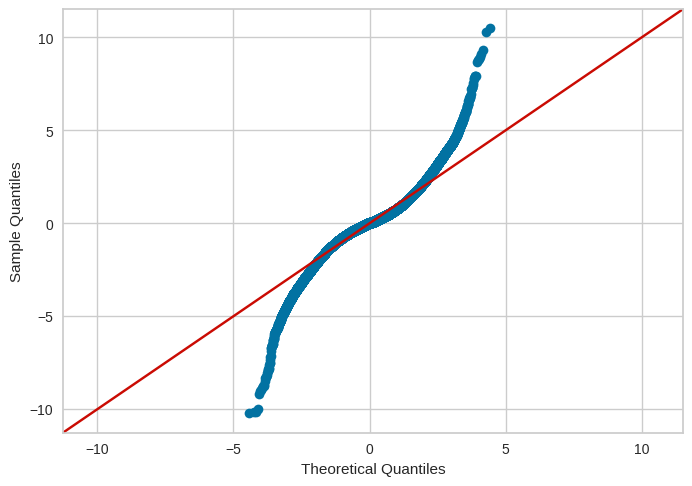

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning:

p-value may not be accurate for N > 5000.



Shapiro-wilk test, p-value = 0.0
D’Agostino-Pearson test, p-value = 0.0
Both statistical tests have p-value<0.05, So the result is statistically significant and the null hypothesis can be rejected.
We conclude that the 'score' data is not normally distributed


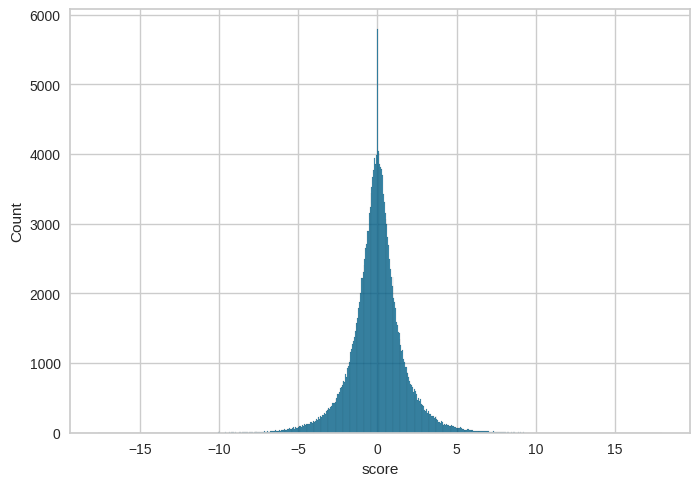

In [ ]:
# Normality test graphical method
# Also we have noticed before that the "score" is normaly distributed after outliers removal we will check it using qq-plots
# use QQ plot and freuqency distribution.

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(transactions_userscore_merged['score'], line='45', fit = True)
plt.show()

#frequency plot "Histogram"
fig = sns.histplot(transactions_userscore_merged['score'])
#fig.show()


# Normality test statistical method
# We will use Shapiro-wilk and D’Agostino-Pearson’s K² normality tests

# Shapiro-wilk test, Its null hypothesis is that the data is normaly distributed
w, pvalue_1 = stats.shapiro(transactions_userscore_merged['score']) #p value obtained from the Shapiro-Wilk test is significant (p < 0.05), we conclude that the data is not normally distributed
print("Shapiro-wilk test, p-value = {}".format(pvalue_1))

# D’Agostino-Pearson’s K² test
k2, pvalue_2 = stats.normaltest(transactions_userscore_merged['score'])
print("D’Agostino-Pearson test, p-value = {}".format(pvalue_2))

# The chosen statistical significance threshold alpha
alpha = 0.05

# null hypothesis: x comes from a normal distribution
if pvalue_1 < alpha and pvalue_2 < alpha:
    print("Both statistical tests have p-value<0.05, So the result is statistically significant and the null hypothesis can be rejected.")
    print("We conclude that the 'score' data is not normally distributed")
elif pvalue_1 > alpha and pvalue_2 > alpha:
    print("Both statistical tests have p-value>0.05, So the result is statistically non-significant and The null hypothesis cannot be rejected.")
    print("We conclude that the 'score' data is normally distributed")
else:
    print("Both tests dont give consistent results, p-values are {} and {}".format(pvalue_1, pvalue_2))


## Additional Features Creation for Hypothesis Testing

We will create 2 new features, one will represent the total amount of authorized purchases per card_id from both historical and new transactions and the other is the sum of authorized purchases amount per card_id from both historical and new transactions.

We calculated these features as we want to see the effect of two factors on loyalty score:
* Total number of transactions
* Total amount of purchases

Mainly to check:
* if card_ids purchasing more often have statistically significant higher loyalty score than card_ids purchasing less - (Comparing number of purchases)
* if card_ids spending higher amounts of money have statistically significant higher loyalty score than card_ids spending less - (Comparing money spent in purchases)

In [ ]:
# create new feature: total number of authorized transactions both in historical and new
total_auth_trans_cnt = transactions_userscore_merged['auth_hist_transactions_count'] + transactions_userscore_merged['new_transactions_count']

# create new feature: total sum of authorized purchase amounts both in historical and new
total_auth_purchase_sum = transactions_userscore_merged['auth_hist_purchase_amount_sum'] + transactions_userscore_merged['new_purchase_amount_sum']


# Creating a dictionary by passing Series objects as values
frame = {'card_id': transactions_userscore_merged['card_id'],
         'auth_trns_cnt': total_auth_trans_cnt,
         'auth_purchase_sum':total_auth_purchase_sum,
         'score': transactions_userscore_merged['score']}

# Creating DataFrame by passing Dictionary
hypo_df = pd.DataFrame(frame)

In [ ]:
# The threshold that we will use in both cases to separate between the higher and lower values will the median to have 50% of cards below it and 50% of cards above

# Median Values
median_trns_cnt = total_auth_trans_cnt.median() # 54
median_purch_amnt = total_auth_purchase_sum.median() # -30.8

# Loyalty scores for first hypothesis test
score_of_high_transactions_cards = hypo_df[hypo_df['auth_trns_cnt'] > median_trns_cnt]['score']
score_of_low_transactions_cards = hypo_df[hypo_df['auth_trns_cnt'] < median_trns_cnt]['score']

# Loyalty scores for second hypothesis test
score_high_purchasing_cards = hypo_df[hypo_df['auth_purchase_sum'] > median_purch_amnt]['score']
score_low_purchasing_cards = hypo_df[hypo_df['auth_purchase_sum'] < median_purch_amnt]['score']

## First Hypothesis Test

Statment: "Customers purchasing more often have higher loyalty score than customers purchasing less"

It is important to check this as to see how the bank evaluates the loyalty score and whether we need do more purchasing if we want to increase our loyalty score or if it has no effect

$H_0$ Null hypothesis: There is no difference between customers that purchase frequently and customers that purchase infrequently in terms of loyalty "score"

$H_1$ Alternative hypothesis: Customers purchasing more have higher loyalty score

In [ ]:
# As we have seen before the loyalty "score" doesn't follow the normal distribution so we should use a non-parametric test
# also we are comparing two groups which are highly unpaired so we will use Mann-Whitney U/ Wilcoxon rank-sum t-test
# we should use Mann-Whitney U test as the data is two groups, non-parametric and unpaired groups with numeric values
# perform one-sided test as we want to see if the score is greater for one group

mannwhitneyu_ttest = stats.mannwhitneyu(x=score_of_high_transactions_cards, y=score_of_low_transactions_cards, alternative = 'greater') # checks if mean of x > mean of y
mannwhitneyu_ttest
p_value = mannwhitneyu_ttest[1]
print("\n" "p-value is:", p_value)

# The chosen statistical significance threshold alpha
alpha = 0.05


if p_value < alpha:
    print("p-value<0.05, the null hypothesis can be rejected.")
    print("We conclude that customers purchasing more often have statistically significant higher loyalty score than customers purchasing less")
else:
    print("p-value>0.05,the null hypothesis cannot be rejected.")
    print("We conclude that there is no statistical significant increase in loyalt 'score' for customers doing more purchases")


# Cliff's Delta Effect-Size

# Will check effect size using cliff's delta as data is non-parametric if parametric use cohen's d
#cliffs_delta(score_of_low_transactions_cards, score_of_high_transactions_cards)

MannwhitneyuResult(statistic=4507321269.5, pvalue=1.0)


p-value is: 1.0
p-value>0.05,the null hypothesis cannot be rejected.
We conclude that there is no statistical significant increase in loyalt 'score' for customers doing more purchases


## Second Hypothesis Test

Statment: "Customers spending more money (buying expensive products) have higher loyalty score than customers spending less"

It is important to check this as to see how the bank evaluates the loyalty score and whether we need to buy more expensive products if we want to increase our loyalty score or if it has no effect

$H_0$ Null hypothesis: There is no difference between customers that spends more money and customers that spend less in terms of loyalty "score"

$H_1$ Alternative hypothesis: Customers spending more have money higher loyalty score

In [ ]:
# we should use Mann-Whitney U test as the data is two groups, non-parametric and unpaired groups with numeric values
# perform one-sided test as we want to see if the score is greater for one group

mannwhitneyu_ttest = stats.mannwhitneyu(x=score_high_purchasing_cards, y=score_low_purchasing_cards, alternative = 'greater') # checks if mean of x > mean of y
mannwhitneyu_ttest
p_value = mannwhitneyu_ttest[1]
print("\n" "p-value is:", p_value)

# The chosen statistical significance threshold alpha
alpha = 0.05


if p_value < alpha:
    print("p-value<0.05, the null hypothesis can be rejected.")
    print("We conclude that customers spending more money have statistically significant higher loyalty score than customers spending less")
else:
    print("p-value>0.05,the null hypothesis cannot be rejected.")
    print("We conclude that there is no statistical significant increase in loyalt 'score' for customers spending more money")


# Cliff's Delta Effect-Size

# Will check effect size using cliff's delta as data is non-parametric if parametric use cohen's d
cliffs_delta(score_of_low_transactions_cards, score_of_high_transactions_cards)

# Since effect size < 0.147, the statistical significant differences between two groups is "negligible".

MannwhitneyuResult(statistic=5365181762.0, pvalue=3.173139010305028e-191)


p-value is: 3.173139010305028e-191
p-value<0.05, the null hypothesis can be rejected.
We conclude that customers spending more money have statistically significant higher loyalty score than customers spending less


(0.08280443677187614, 'negligible')

# **Regression Analysis**
   


## Merged Data Final Preprocessing

Till now we've obtained our final merged dataset that has the card_ids userscore and their aggregated transactions we will do final preprocessing steps on our merged data such as encoding categorical variables and performing any needed scaling for numerical features


In [ ]:
# check if we need to drop any columns

# Checking datatypes
transactions_userscore_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199710 entries, 0 to 199709
Data columns (total 45 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   card_id                                   199710 non-null  object 
 1   feature_1                                 199710 non-null  int64  
 2   feature_2                                 199710 non-null  int64  
 3   feature_3                                 199710 non-null  int64  
 4   score                                     199710 non-null  float64
 5   card_relative_age                         199710 non-null  int64  
 6   auth_hist_transactions_count              199710 non-null  int64  
 7   auth_hist_city_id_nunique                 199710 non-null  int64  
 8   auth_hist_category_1_sum                  199710 non-null  int64  
 9   auth_hist_installments_mean               199710 non-null  float64
 10  auth_hist_category_3

### Adjust some features datatype

In [ ]:
transactions_userscore_merged['auth_hist_category_2_<lambda>'] = transactions_userscore_merged['auth_hist_category_2_<lambda>'].astype('category')
transactions_userscore_merged['unauth_hist_category_2_<lambda>'] = transactions_userscore_merged['unauth_hist_category_2_<lambda>'].astype('category')
transactions_userscore_merged['new_category_2_<lambda>'] = transactions_userscore_merged['new_category_2_<lambda>'].astype('category')
transactions_userscore_merged['feature_1'] = transactions_userscore_merged['feature_1'].astype('category')
transactions_userscore_merged['feature_2'] = transactions_userscore_merged['feature_2'].astype('category')
transactions_userscore_merged['feature_3'] = transactions_userscore_merged['feature_3'].astype('category')

### Cut out more outliers were |score| > 7.5

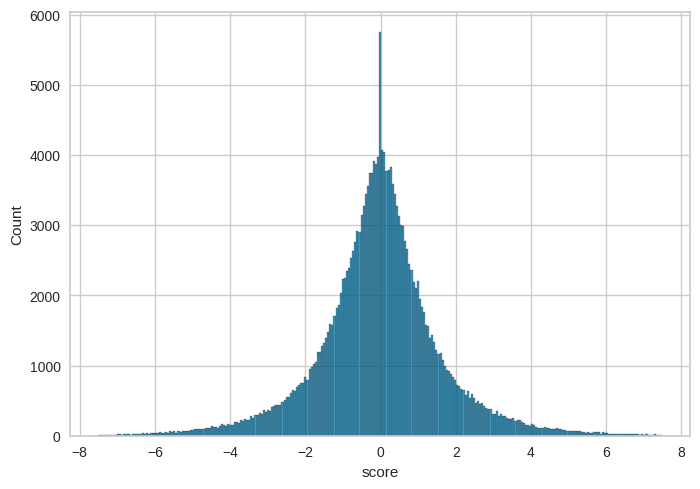

In [ ]:
transactions_userscore_merged = transactions_userscore_merged[abs(transactions_userscore_merged['score']) < 7.5]
#frequency plot "Histogram"
fig = sns.histplot(transactions_userscore_merged['score'])
#fig.show()

### Features/columns datatypes extraction

In [ ]:
# Filtering out categorical features that will need one hot enconding
transactions_userscore_merged.select_dtypes(exclude=np.number).info()

<class 'pandas.core.frame.DataFrame'>
Index: 199224 entries, 0 to 199709
Data columns (total 10 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   card_id                          199224 non-null  object  
 1   feature_1                        199224 non-null  category
 2   feature_2                        199224 non-null  category
 3   feature_3                        199224 non-null  category
 4   auth_hist_category_3_<lambda>    199224 non-null  object  
 5   auth_hist_category_2_<lambda>    199224 non-null  category
 6   unauth_hist_category_3_<lambda>  199224 non-null  object  
 7   unauth_hist_category_2_<lambda>  199224 non-null  category
 8   new_category_3_<lambda>          199224 non-null  object  
 9   new_category_2_<lambda>          199224 non-null  category
dtypes: category(6), object(4)
memory usage: 8.7+ MB


In [ ]:
categorical_cols = transactions_userscore_merged.select_dtypes(exclude=np.number).columns

numeric_cols = [col for col in transactions_userscore_merged.columns if col not in categorical_cols ]
numeric_cols

['score',
 'card_relative_age',
 'auth_hist_transactions_count',
 'auth_hist_city_id_nunique',
 'auth_hist_category_1_sum',
 'auth_hist_installments_mean',
 'auth_hist_merchant_category_id_nunique',
 'auth_hist_merchant_id_nunique',
 'auth_hist_month_lag_max',
 'auth_hist_month_lag_min',
 'auth_hist_purchase_amount_sum',
 'auth_hist_state_id_nunique',
 'auth_hist_subsector_id_nunique',
 'unauth_hist_transactions_count',
 'unauth_hist_city_id_nunique',
 'unauth_hist_category_1_sum',
 'unauth_hist_installments_mean',
 'unauth_hist_merchant_category_id_nunique',
 'unauth_hist_merchant_id_nunique',
 'unauth_hist_month_lag_max',
 'unauth_hist_month_lag_min',
 'unauth_hist_purchase_amount_sum',
 'unauth_hist_state_id_nunique',
 'unauth_hist_subsector_id_nunique',
 'new_transactions_count',
 'new_city_id_nunique',
 'new_category_1_sum',
 'new_installments_mean',
 'new_merchant_category_id_nunique',
 'new_merchant_id_nunique',
 'new_month_lag_max',
 'new_month_lag_min',
 'new_purchase_amount_s

In [ ]:
#  Now we need to perform one hot encoding for categorical variables
# but first we'll need to check for skewed(non-normal) features and perform any needed transformation such as log-trnasform
# as linear regression will make more reliable predictions if your input and output variables have a normal distribution


# First we will make a copy of the df
merged_data = transactions_userscore_merged.copy()

# Remove 'card_id' column
merged_data.drop(['card_id'], axis=1, inplace=True)

### Correlation Analysis to check if we need to remove any highly correlated features to avoid overfitting

<Axes: >

<Axes: >

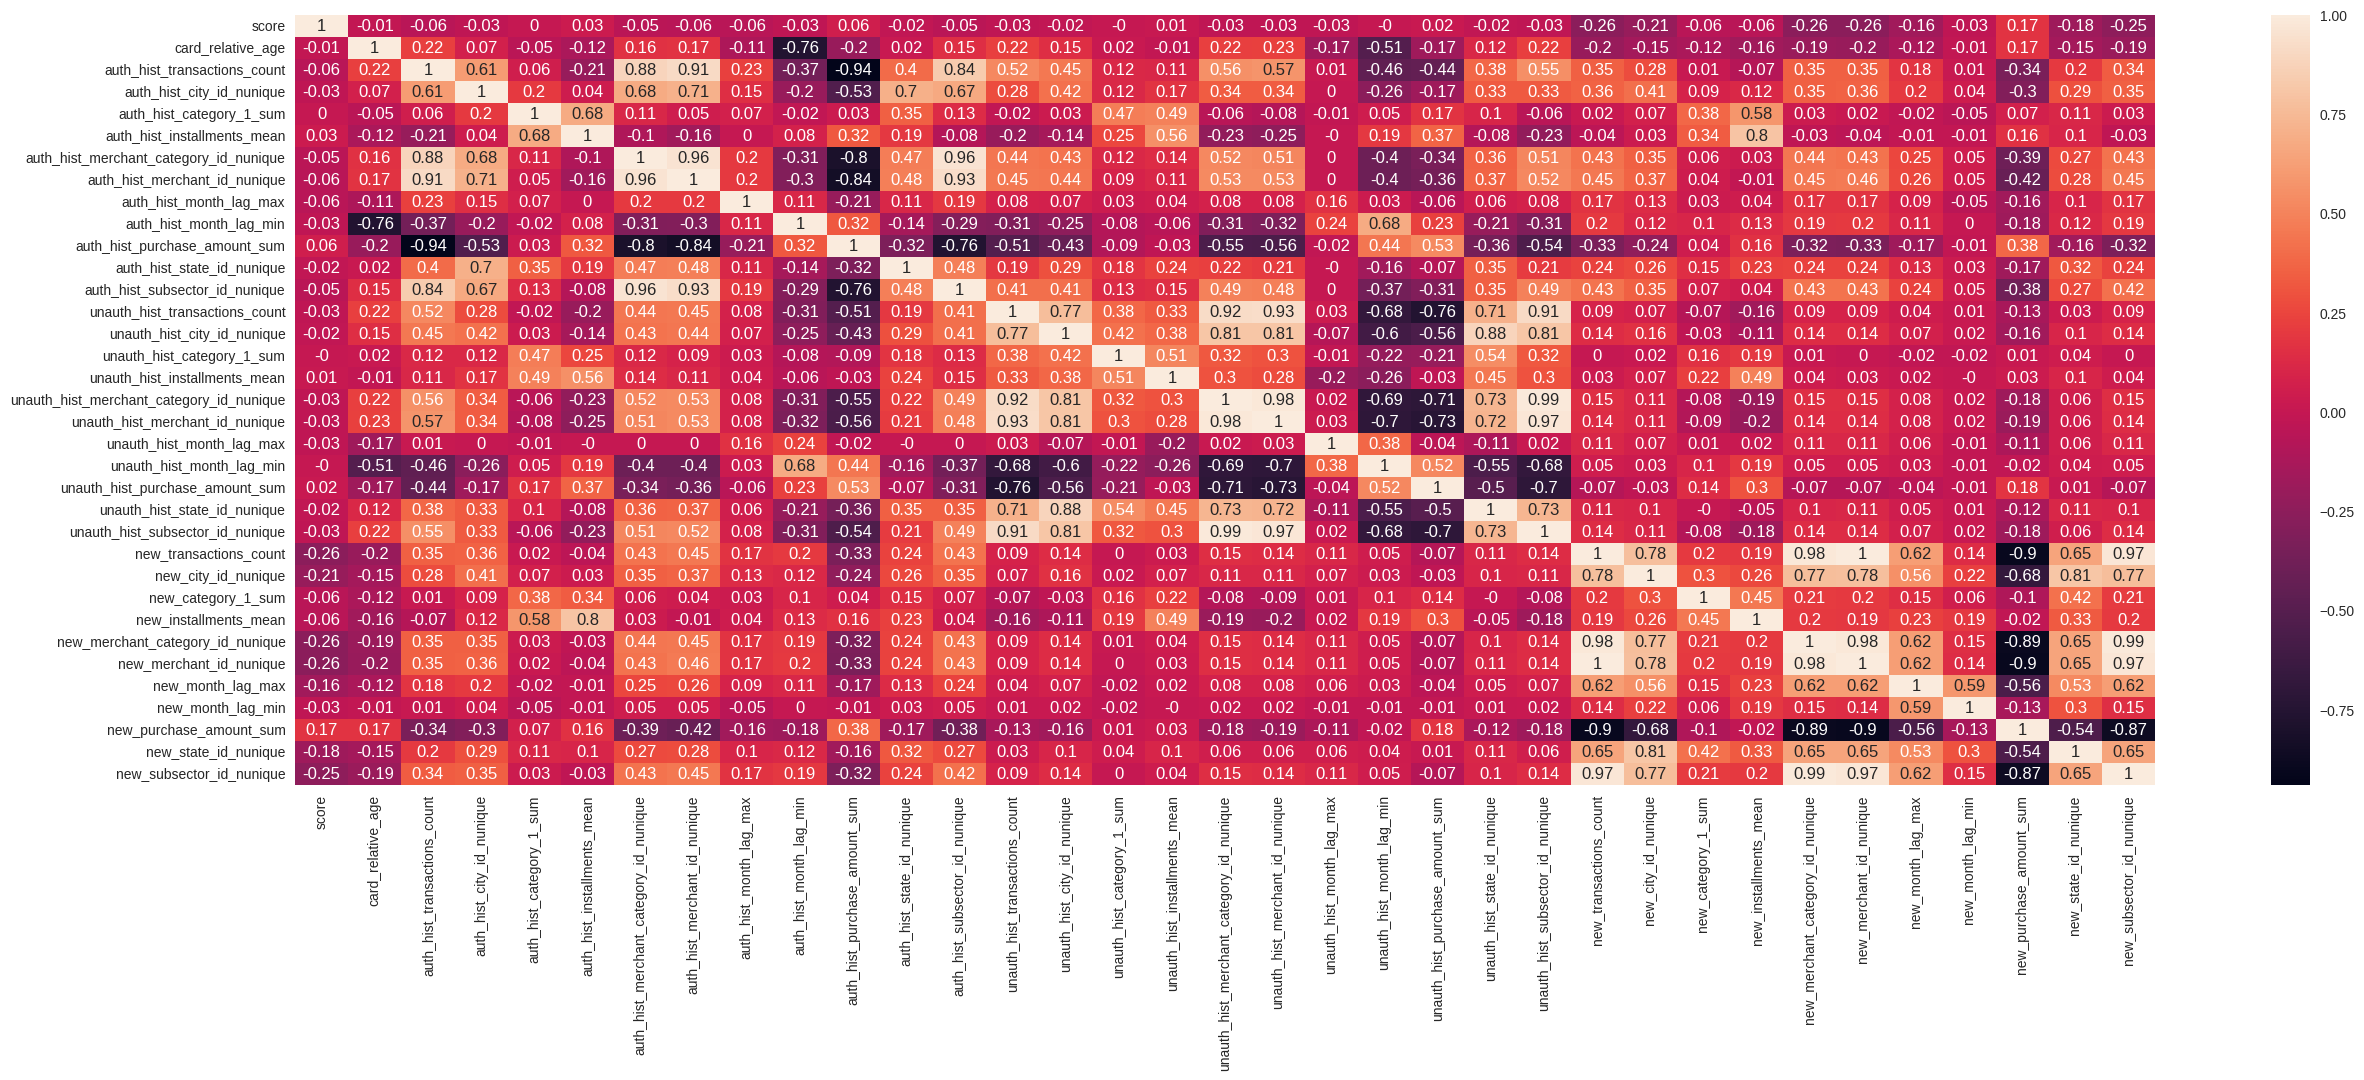

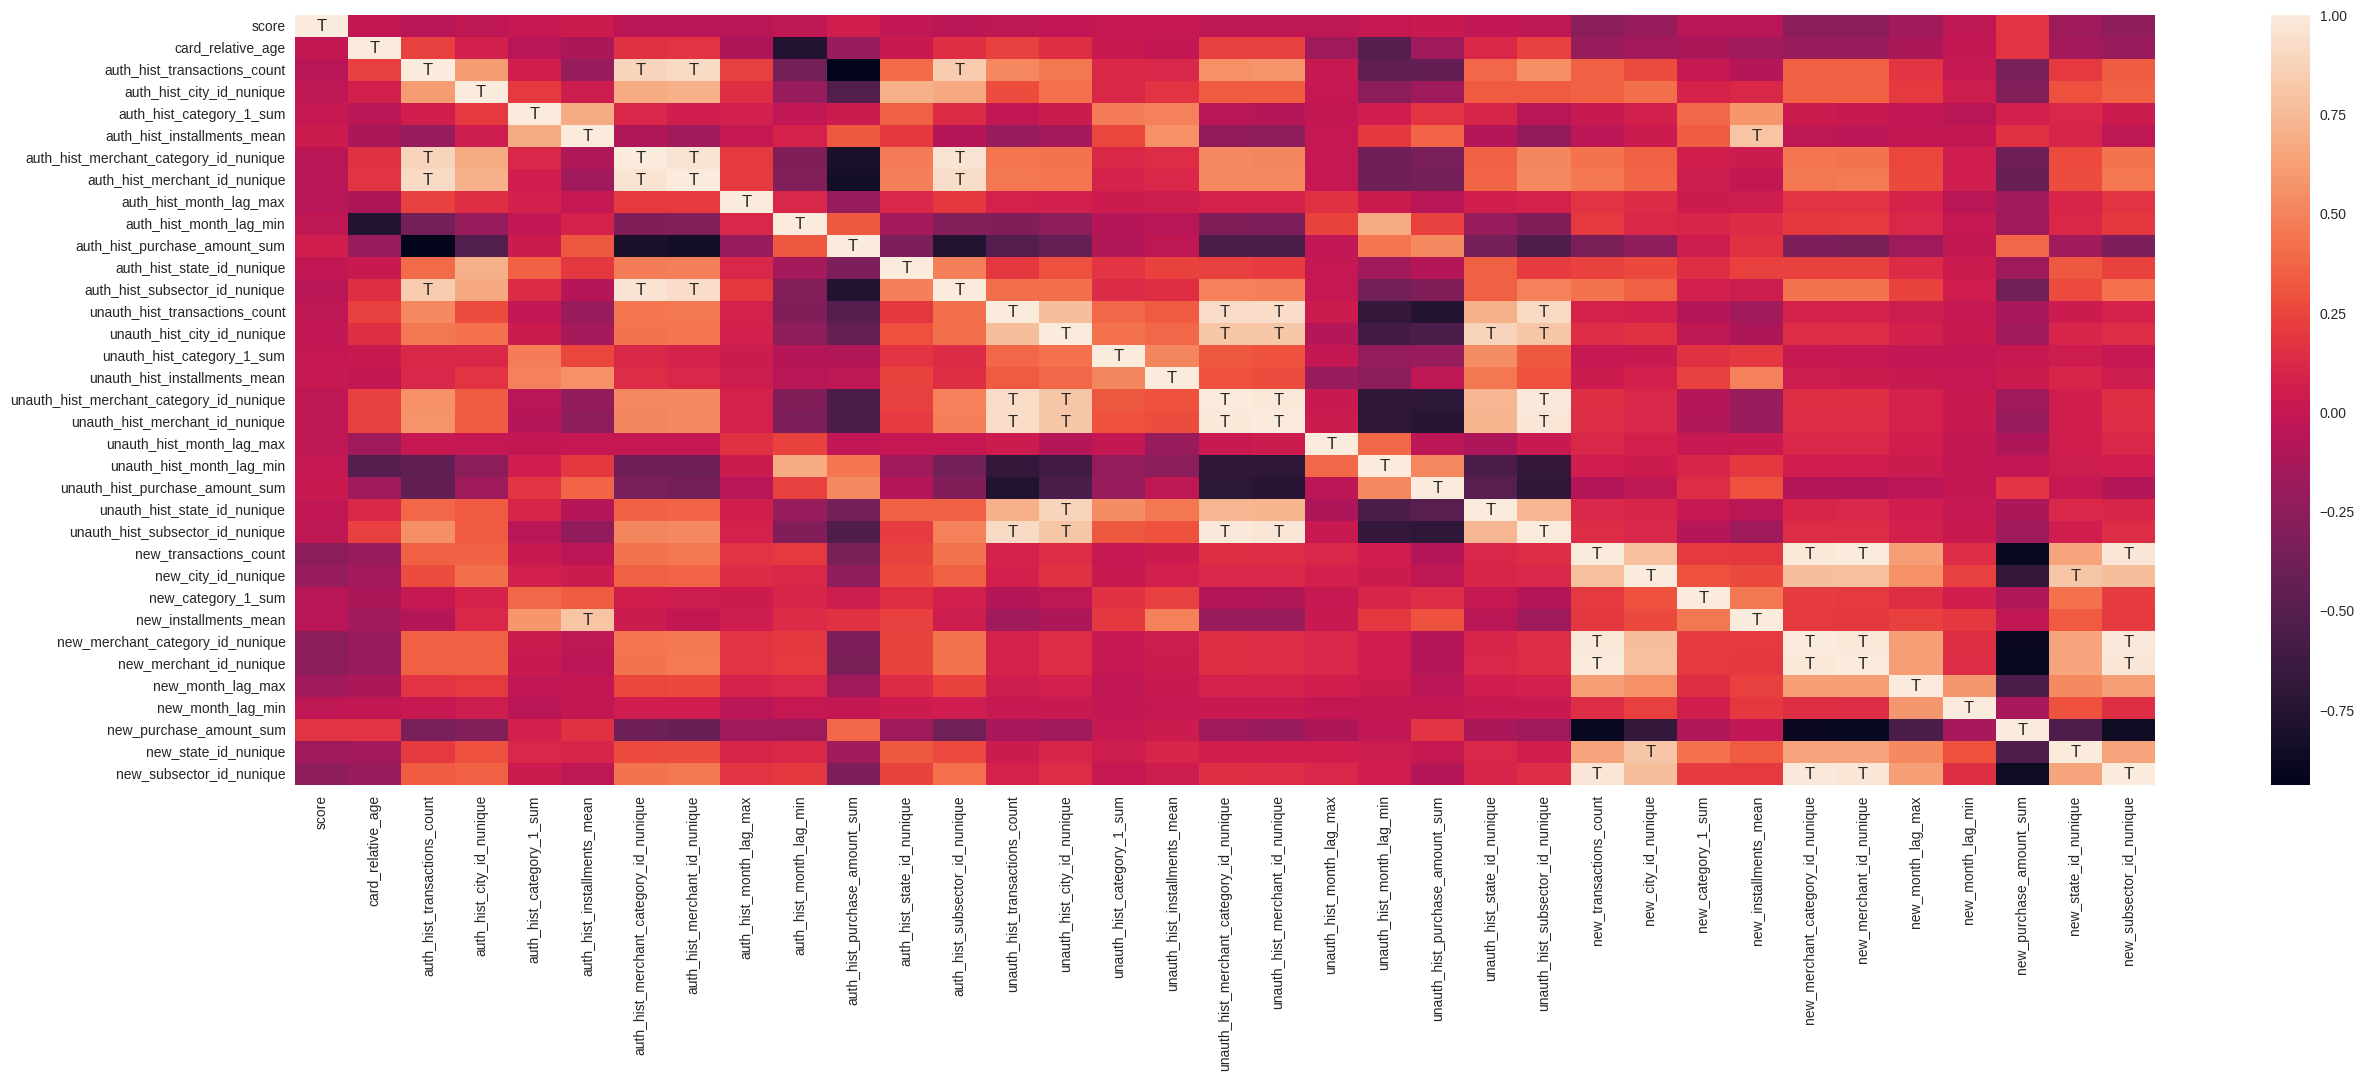

In [ ]:
# Numeric Features Correlation
fig, ax = plt.subplots(figsize=(30, 10))
cor_df = merged_data[numeric_cols].corr(method = "spearman").round(2) # spearman is used for numerical-numerical non parametric features correlation
sns.heatmap(cor_df, ax=ax, annot=True)

# Generate annotation labels array (of the same size as the heatmap data)- filling cells you don't want to annotate with an empty string ''
annot_labels = np.empty_like(cor_df, dtype=str)
annot_mask = cor_df >= 0.8
annot_labels[annot_mask] = 'T'
# Plot hearmap with the annotations
fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(cor_df, annot=annot_labels, fmt='')

Highly correlated features drop

In [ ]:
corr_ser = cor_df.abs().unstack()
corr_ser = corr_ser.sort_values(ascending = False, kind = 'quicksort')
# convert series to dataframe
df = corr_ser.reset_index()
df.columns = ["feature_1",  "feature_2", "corrl"]
df.drop_duplicates(inplace=True)

# filter on features of corr>0.8
df = df[df['corrl']>0.8]

# filter where feature 1 is not feature 2
df = df[df["feature_1"] != df["feature_2"]]

unique_corrl_features = df['feature_2'].unique() # features to drop having correlation > 80%
#len(unique_features) # number of features to drop

columns_to_keep = ['new_transactions_count','unauth_hist_transactions_count',
 'new_merchant_id_nunique','unauth_hist_merchant_id_nunique','auth_hist_merchant_id_nunique',
 'auth_hist_purchase_amount_sum','auth_hist_transactions_count',
 'new_purchase_amount_sum','unauth_hist_city_id_nunique','new_state_id_nunique']

columns_to_drop = [col for col in unique_corrl_features if col not in columns_to_keep]
columns_to_drop

['new_subsector_id_nunique',
 'new_merchant_category_id_nunique',
 'unauth_hist_merchant_category_id_nunique',
 'unauth_hist_subsector_id_nunique',
 'auth_hist_merchant_category_id_nunique',
 'auth_hist_subsector_id_nunique',
 'unauth_hist_state_id_nunique',
 'new_city_id_nunique']

In [ ]:
features_without_colinearity = [col for col in merged_data.columns if col not in columns_to_drop]
merged_data = merged_data[features_without_colinearity]
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199224 entries, 0 to 199709
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   feature_1                        199224 non-null  category
 1   feature_2                        199224 non-null  category
 2   feature_3                        199224 non-null  category
 3   score                            199224 non-null  float64 
 4   card_relative_age                199224 non-null  int64   
 5   auth_hist_transactions_count     199224 non-null  int64   
 6   auth_hist_city_id_nunique        199224 non-null  int64   
 7   auth_hist_category_1_sum         199224 non-null  int64   
 8   auth_hist_installments_mean      199224 non-null  float64 
 9   auth_hist_category_3_<lambda>    199224 non-null  object  
 10  auth_hist_merchant_id_nunique    199224 non-null  int64   
 11  auth_hist_month_lag_max          199224 non-null  int64  

<Axes: >

<Axes: >

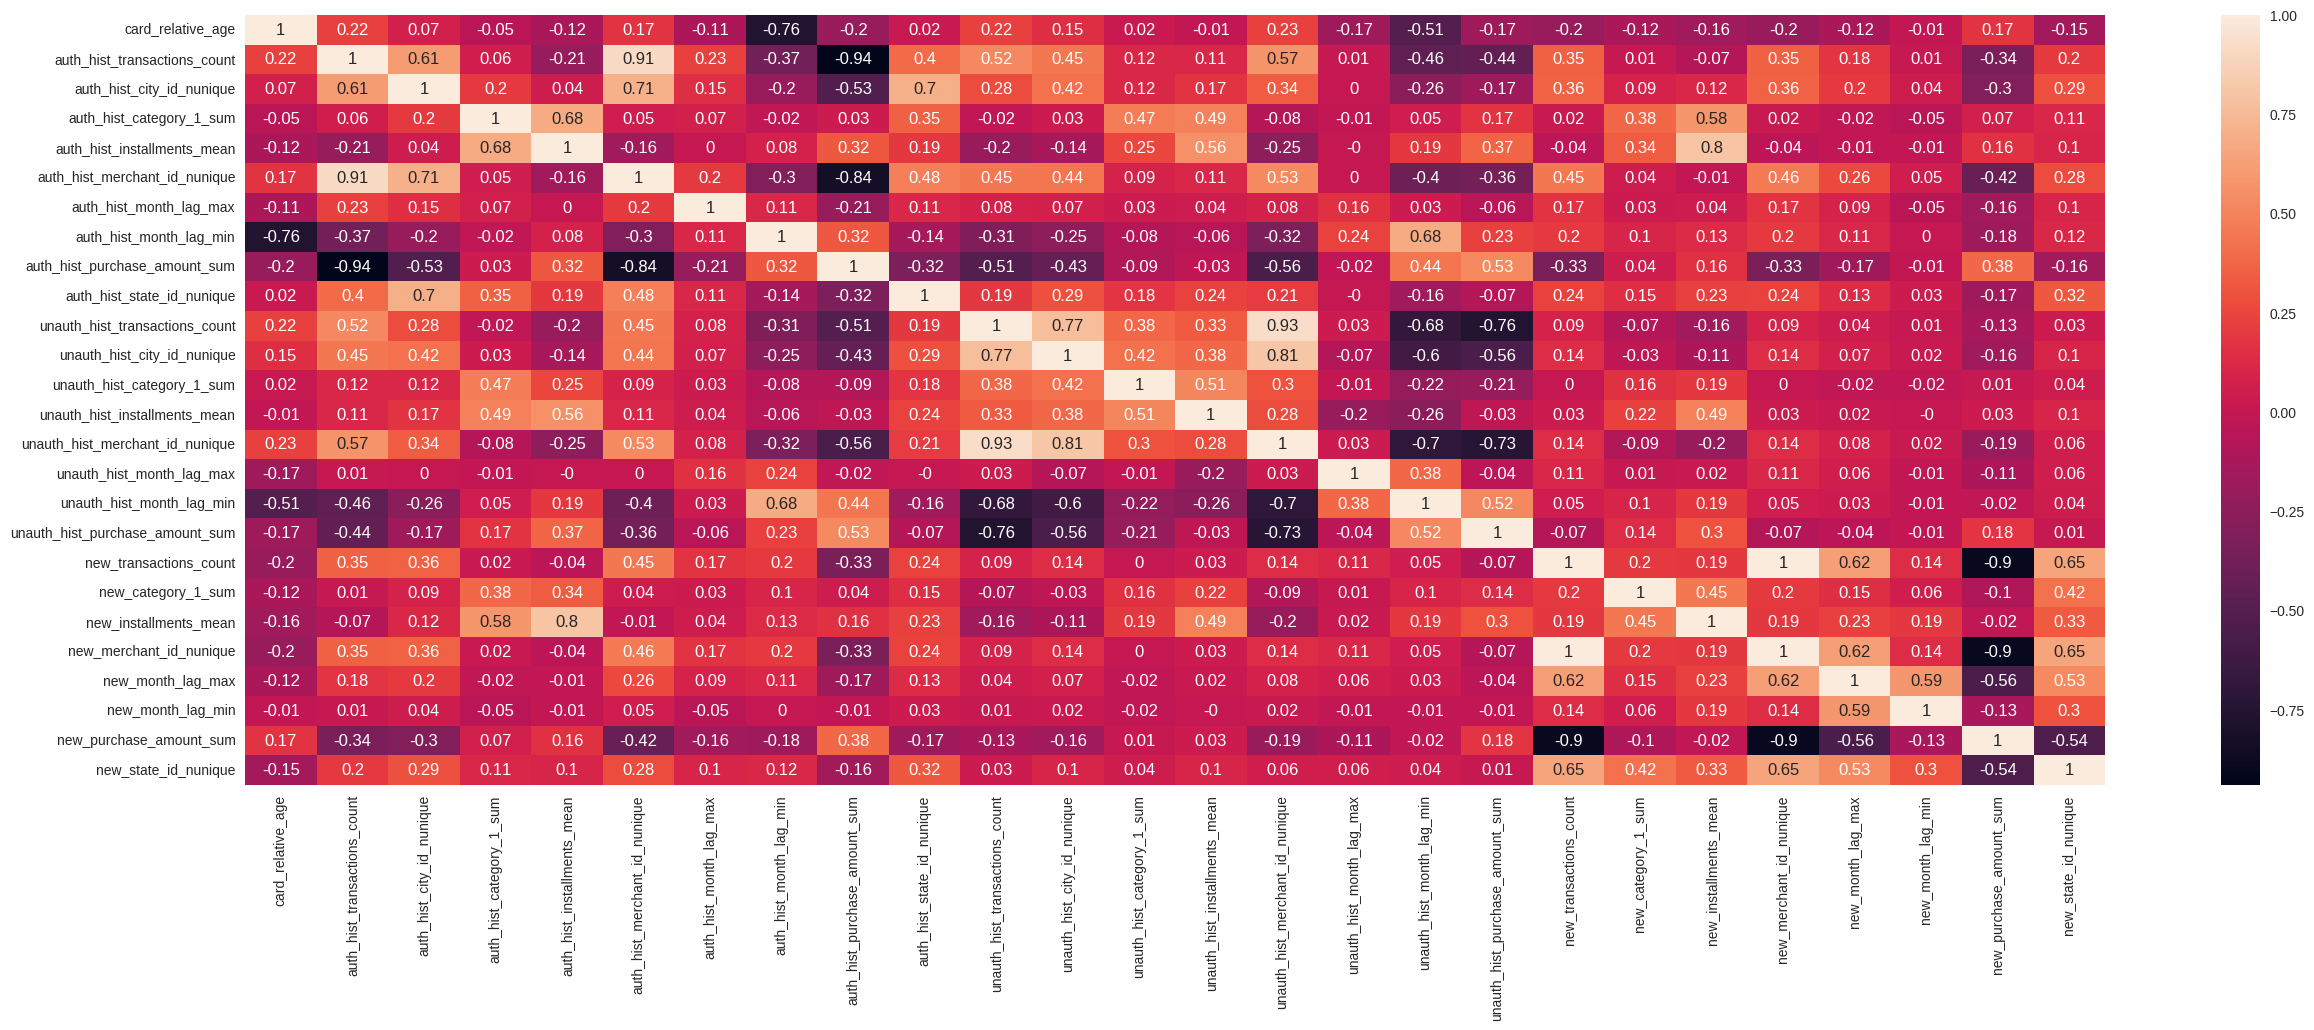

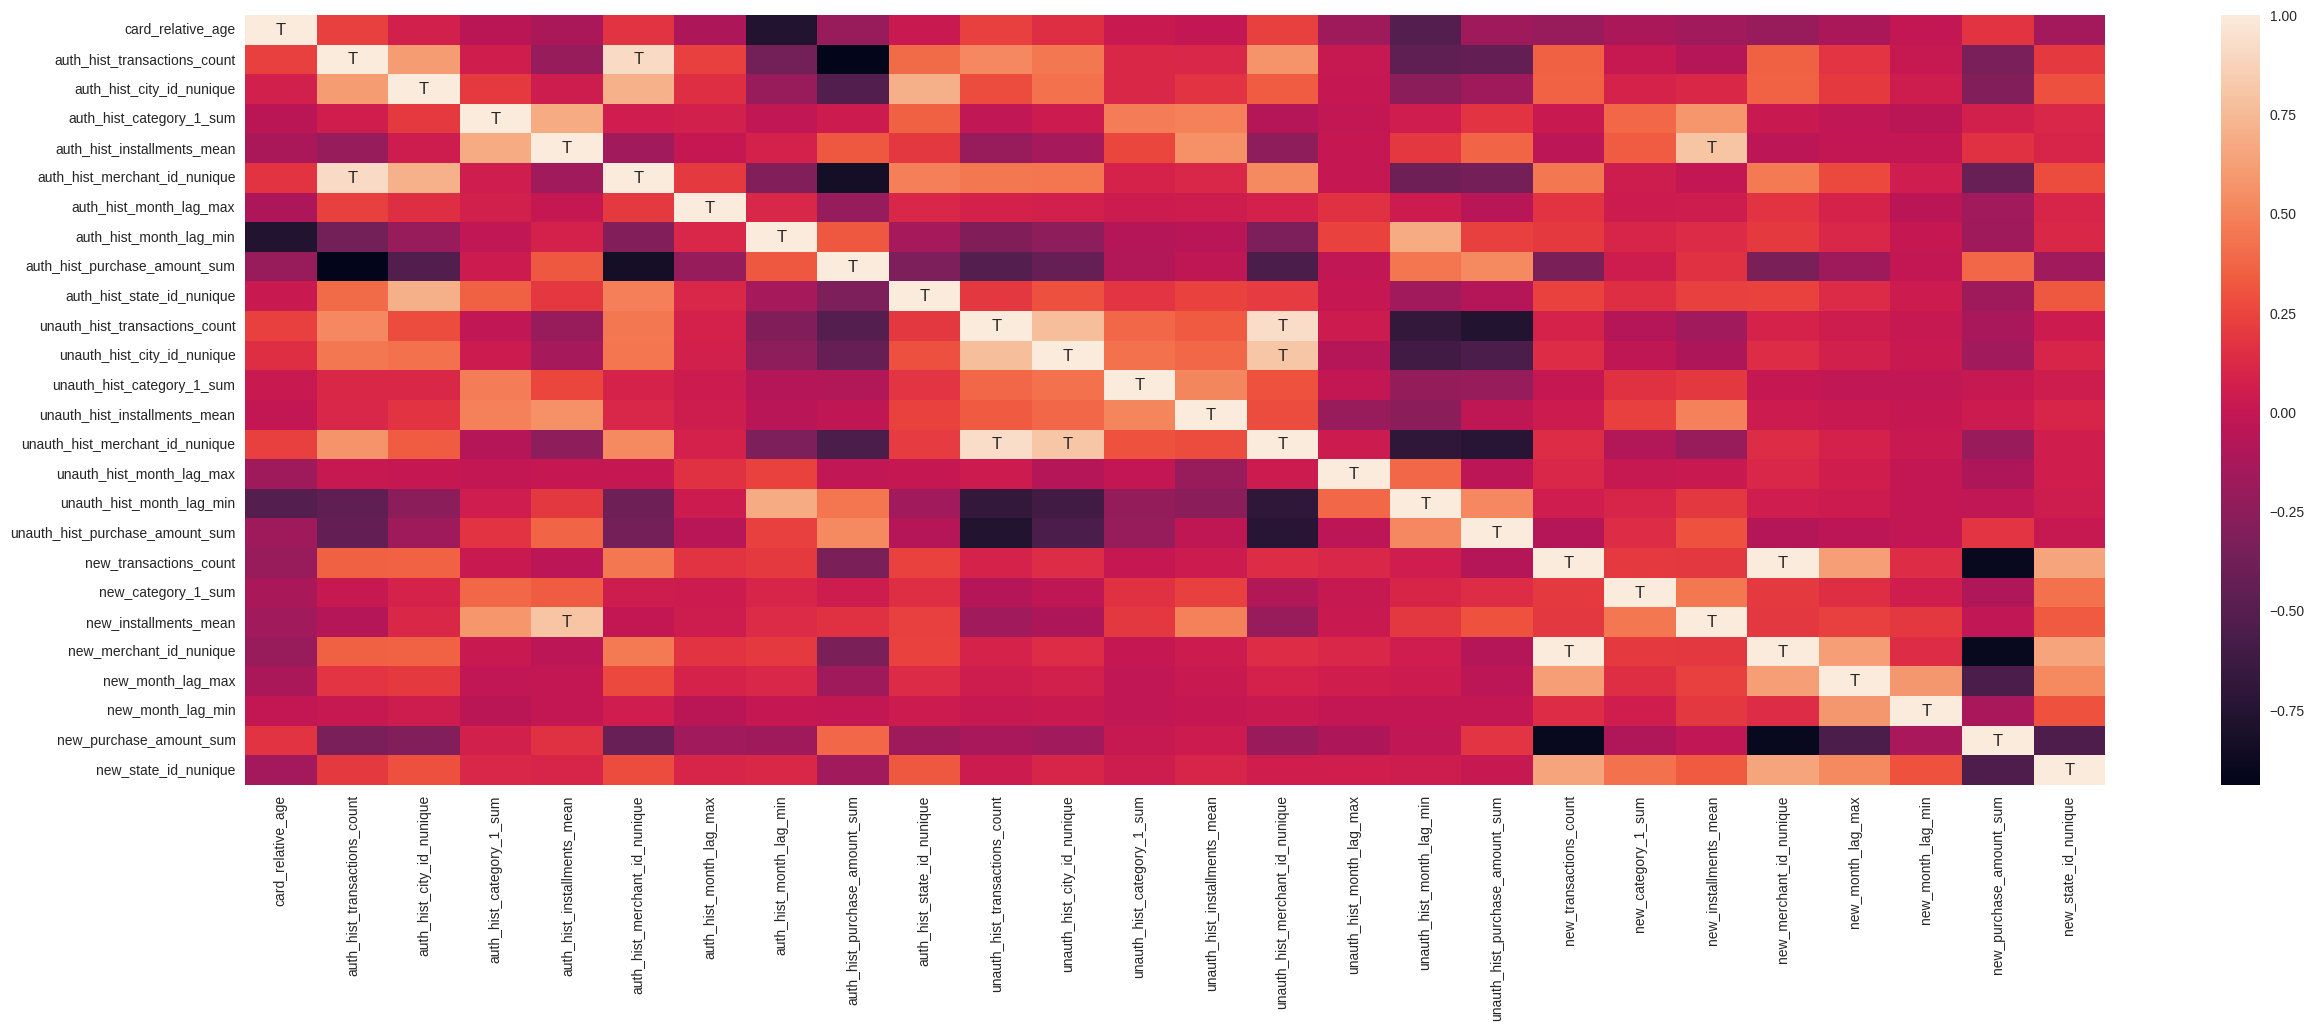

In [ ]:
# Q6)
categorical_cols = merged_data.select_dtypes(exclude=np.number).columns

numeric_cols = [col for col in merged_data.columns if col not in categorical_cols ]


# Numeric Features Correlation Re-assess
fig, ax = plt.subplots(figsize=(30, 10))
cor_df = merged_data[numeric_cols].corr(method = "spearman").round(2) # spearman is used for numerical-numerical non parametric features correlation
sns.heatmap(cor_df, ax=ax, annot=True)

# Generate annotation labels array (of the same size as the heatmap data)- filling cells you don't want to annotate with an empty string ''
annot_labels = np.empty_like(cor_df, dtype=str)
annot_mask = cor_df >= 0.8
annot_labels[annot_mask] = 'T'
# Plot hearmap with the annotations
fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(cor_df, annot=annot_labels, fmt='')


There are still colinearity in the features masked by T symbol

### Calculate features skewness as linear regression assumes features to be normaly distributed

In [ ]:
# Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean, the skewness value can be positive, zero, negative, or undefined
skewness = merged_data[numeric_cols].skew().sort_values(ascending=False)
skewness[abs(skewness) > 1] # highly skewed features

unauth_hist_purchase_amount_sum    439.339143
unauth_hist_category_1_sum          58.185164
unauth_hist_transactions_count      17.043202
auth_hist_category_1_sum            11.118791
new_category_1_sum                   4.241050
new_installments_mean                3.597188
auth_hist_transactions_count         3.426870
unauth_hist_installments_mean        3.291080
auth_hist_city_id_nunique            2.699368
new_merchant_id_nunique              2.511032
new_transactions_count               2.509499
auth_hist_merchant_id_nunique        2.341478
unauth_hist_merchant_id_nunique      2.282838
card_relative_age                    1.712044
auth_hist_state_id_nunique           1.706100
auth_hist_installments_mean          1.632160
new_state_id_nunique                 1.464014
unauth_hist_city_id_nunique          1.338314
new_month_lag_max                   -1.527982
auth_hist_purchase_amount_sum       -2.060268
unauth_hist_month_lag_max           -2.145688
auth_hist_month_lag_max           

In [ ]:
# List of skewed columns
skewed_cols = list(skewness[abs(skewness) > 1].index) # returns the columns "features" names that are highly skewed in a list
skewed_cols

['unauth_hist_purchase_amount_sum',
 'unauth_hist_category_1_sum',
 'unauth_hist_transactions_count',
 'auth_hist_category_1_sum',
 'new_category_1_sum',
 'new_installments_mean',
 'auth_hist_transactions_count',
 'unauth_hist_installments_mean',
 'auth_hist_city_id_nunique',
 'new_merchant_id_nunique',
 'new_transactions_count',
 'auth_hist_merchant_id_nunique',
 'unauth_hist_merchant_id_nunique',
 'card_relative_age',
 'auth_hist_state_id_nunique',
 'auth_hist_installments_mean',
 'new_state_id_nunique',
 'unauth_hist_city_id_nunique',
 'new_month_lag_max',
 'auth_hist_purchase_amount_sum',
 'unauth_hist_month_lag_max',
 'auth_hist_month_lag_max']

In [ ]:
# Log-transform skewed columns
for col_name in skewed_cols:
    const = -(merged_data[col_name].min())+0.01
    merged_data[col_name] = np.log(const+ merged_data[col_name])

### One Hot Enconding

In [ ]:
# Categorical features one hot encoding
merged_data_ohe = pd.get_dummies(merged_data)

merged_data_ohe.head()

,score,card_relative_age,auth_hist_transactions_count,auth_hist_city_id_nunique,auth_hist_category_1_sum,auth_hist_installments_mean,auth_hist_merchant_id_nunique,auth_hist_month_lag_max,auth_hist_month_lag_min,auth_hist_purchase_amount_sum,auth_hist_state_id_nunique,unauth_hist_transactions_count,unauth_hist_city_id_nunique,unauth_hist_category_1_sum,unauth_hist_installments_mean,unauth_hist_merchant_id_nunique,unauth_hist_month_lag_max,unauth_hist_month_lag_min,unauth_hist_purchase_amount_sum,new_transactions_count,new_category_1_sum,new_installments_mean,new_merchant_id_nunique,new_month_lag_max,new_month_lag_min,new_purchase_amount_sum,new_state_id_nunique,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_3_0,feature_3_1,auth_hist_category_3_<lambda>_A,auth_hist_category_3_<lambda>_B,auth_hist_category_3_<lambda>_C,auth_hist_category_2_<lambda>_1.0,auth_hist_category_2_<lambda>_2.0,auth_hist_category_2_<lambda>_3.0,auth_hist_category_2_<lambda>_4.0,auth_hist_category_2_<lambda>_5.0,unauth_hist_category_3_<lambda>_A,unauth_hist_category_3_<lambda>_B,unauth_hist_category_3_<lambda>_C,unauth_hist_category_2_<lambda>_1.0,unauth_hist_category_2_<lambda>_2.0,unauth_hist_category_2_<lambda>_3.0,unauth_hist_category_2_<lambda>_4.0,unauth_hist_category_2_<lambda>_5.0,new_category_3_<lambda>_A,new_category_3_<lambda>_B,new_category_3_<lambda>_C,new_category_2_<lambda>_1.0,new_category_2_<lambda>_2.0,new_category_2_<lambda>_3.0,new_category_2_<lambda>_4.0,new_category_2_<lambda>_5.0
0,-0.820283,5.501299,5.501299,1.793425,-4.605170,-4.605170,4.521897,2.398804,-8,7.418503,0.698135,2.565718,0.698135,-4.605170,-1.146672,2.565718,2.398804,-7.0,6.912311,3.135929,-4.605170,-4.605170,3.135929,0.698135,1.0,-13.244202,0.009950,False,False,False,False,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False
1,0.392913,5.981439,5.820113,2.080691,3.367641,0.403879,4.941714,2.398804,-12,7.387121,0.698135,2.398804,0.698135,0.698135,1.342390,2.198335,2.485740,-10.0,6.919699,1.793425,-4.605170,0.009950,1.793425,0.698135,1.0,-4.355735,0.009950,False,False,False,True,False,True,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,True,False,False,False,False
2,0.688056,6.308117,3.663818,1.388791,-4.605170,-4.605170,2.485740,2.398804,-13,7.493376,0.009950,0.698135,0.009950,-4.605170,-4.605170,0.009950,1.101940,-12.0,6.919485,0.009950,-4.605170,-4.605170,0.009950,0.698135,2.0,-0.700326,0.009950,False,True,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True
3,0.142495,5.030503,4.317621,1.793425,2.485740,0.134376,3.892024,2.398804,-5,7.481241,1.388791,-4.605170,-4.605170,-4.605170,-4.605170,-4.605170,2.565718,0.0,6.920808,1.947338,0.009950,-0.028801,1.947338,0.698135,1.0,-4.654372,0.698135,False,False,False,True,False,False,False,True,True,False,False,True,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False
4,-0.159749,4.521897,4.836361,1.611436,2.485740,0.126633,4.159039,2.398804,-3,7.470163,1.611436,1.611436,0.698135,1.101940,2.029463,0.698135,2.565718,-1.0,6.940698,3.583797,0.698135,0.029863,3.583797,0.698135,1.0,-19.926237,1.611436,True,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,True,False,False,False,False,True,False


### Train-test Split

In [ ]:
# Before we start preprocessing, we need train/test split:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(merged_data_ohe, test_size=0.25)
len(df_train), len(df_test)


(149418, 49806)

### Numeric features scaling

In [ ]:
# Nmeric Features scaling

#for sale_price we do not want to scale it
numeric_cols.remove('score')

scaler = RobustScaler()
# training set
df_train[numeric_cols] = scaler.fit_transform(df_train[numeric_cols])

# testing set
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

In [ ]:
# features
X_train = df_train.drop(['score'], axis='columns')
X_test  = df_test.drop(['score'], axis='columns')

# labels
y_train = df_train['score']
y_test = df_test['score']

## Modeling

Ridge(alpha=20.0)
RMSE train: 1.5615690316563928
RMSE test: 1.5654457465426026


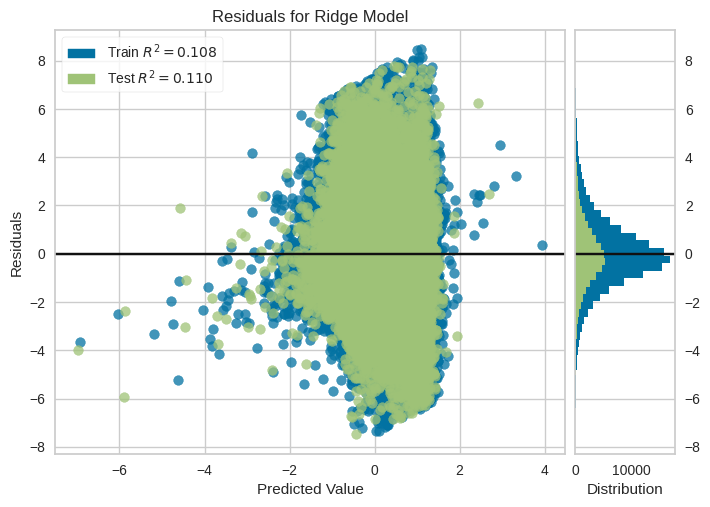

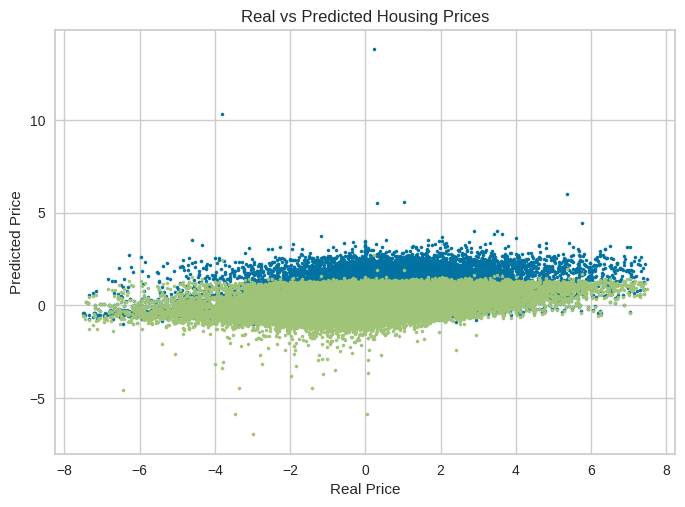

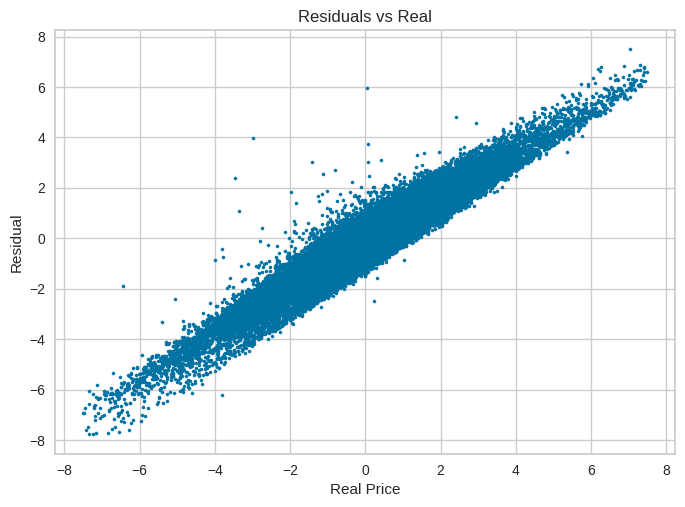

In [ ]:
# Using the same template that was provided at Tutorial1_part2 we will train and fit linear regression models
# Models Instantiation

# a multiple linear regression model
model_base = linear_model.LinearRegression()

# With Ridge
lambda_list_ridge = list(np.linspace(20, 25, 101))
model_ridge = Ridge(alpha=lambda_list_ridge[0])

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def train_test(model):
    print(model)
    model.fit(X_train.values, y_train.values)
    print("RMSE train: {}".format(rmse(y_train.values, model.predict(X_train.values))))
    print("RMSE test: {}".format(rmse(y_test.values,  model.predict(X_test.values))))

    visualizer = ResidualsPlot(model)

    visualizer.fit(X_train.values, y_train.values)  # Fit the training data to the visualizer
    visualizer.score(X_test.values, y_test.values)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure
    plt.scatter(y_test, np.exp(model.predict(X_test.values))-1, s=5 )

    # Real vs Predicted Housing Prices Plotting
    plt.scatter(y_test, model.predict(X_test.values), s=5 )
    plt.xlabel('Real Price')
    plt.ylabel('Predicted Price')
    plt.title( "Real vs Predicted Housing Prices")
    plt.show()

    # Error (Residuals) vs Real Plotting
    plt.scatter( y_test,y_test-model.predict(X_test.values), s=5)
    plt.xlabel('Real Price')
    plt.ylabel('Residual')
    plt.title( "Residuals vs Real")
    plt.show()


train_test(model_ridge)

In [ ]:
# Features that are significantly relevant to sale price based on the results of regression model can be obtained by checking which features have the highest coefficients. Below we list them.

pd.DataFrame(zip(X_train.columns,model_ridge.coef_ )).sort_values(by = 1)

,0,1
18,new_transactions_count,-0.832897
6,auth_hist_month_lag_max,-0.425599
20,new_installments_mean,-0.378425
52,new_category_3_<lambda>_A,-0.289004
37,auth_hist_category_3_<lambda>_B,-0.257770
24,new_purchase_amount_sum,-0.248776
0,card_relative_age,-0.197692
21,new_merchant_id_nunique,-0.175803
38,auth_hist_category_3_<lambda>_C,-0.172762
10,unauth_hist_transactions_count,-0.162821


In [ ]:
merged_data_ohe['score'].max()
merged_data_ohe['score'].min()

7.48619388

-7.49929793

 - determine what features to use
and which regression model to use:
     - In our regression model in selecting which features to use we should remove collinearity as linear regression can over-fit the data when we have highly correlated input variables.
     - We should consider calculating pairwise correlations for your input data and removing the most correlated ones
     - We calculated spearman correlation and filtered in a number of hihly correlated features
     - For our model selection we chose linear regression with ridge regularization to reduce overfitting.
     

 - multicollinearity Check:

     - using the correlation matrix again we notice that there are features that are still highly correlated and not removed
     
 - model performance on train and test.:

     - RMSE train: 1.5615690316563928
     - RMSE test: 1.5654457465426026
     - We notice that train and test are very close to each other which might indicate a good fit, however
     - When compared to range of the loyalty score which is from 7.489 to -7.499 the model is underfitting as error is 30% of target value which is very large (1.5^2 / 7.5) x 100  